## Pothole Detection using RCNN Round 1 of training

We will train FasterRCNN model using torchvision on the Pothole Dataset with COCO JSON annotations

Train for 40 epochs with learning rate = 0.005 with a patience of 5 epochs against validation mean Average Precision (mAP)

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip show torchvision

Name: torchvision
Version: 0.20.1+cu124
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pillow, torch
Required-by: fastai, timm


In [ ]:
!pip install bbox-utils

In [ ]:
import os
import cv2
import torch
import numpy as np
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from collections import defaultdict
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
import copy
from pycocotools.cocoeval import COCOeval
import json

In [ ]:
from bbox_utils.bbox_2d import BoundingBox

In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define paths
data_dir = "/content/drive/My Drive/Omdena_Pothole/Yolo_Coco_Images"

# Prepare datasets
train_root = os.path.join(data_dir, "train/images")
val_root = os.path.join(data_dir, "valid/images")
test_root = os.path.join(data_dir, "test/images")

train_annFile = os.path.join(train_root, "train_annotations.coco.json")
val_annFile = os.path.join(val_root, "valid_annotations.coco.json")
test_annFile = os.path.join(test_root, "test_annotations.coco.json")

# Hyperparameters
num_classes = 5  # 4 pothole classes + 1 background class
batch_size = 4
num_epochs = 40
learning_rate = 0.005
momentum = 0.9
weight_decay = 0.0005
step_size = 3
gamma = 0.1
patience = 5

BEST_MODEL_PATH = "/content/drive/My Drive/Omdena_Pothole/Models/pothole_rcnn_best.pth"

In [ ]:
# Load COCO annotations
coco_train = COCO(os.path.join(train_root, train_annFile))
coco_val = COCO(os.path.join(val_root, val_annFile))
coco_test = COCO(os.path.join(test_root, test_annFile))

# Custom Dataset Class
class PotholeDataset(Dataset):
    def __init__(self, root, coco, transforms=None):
        self.root = root
        self.coco = coco
        self.transforms = transforms
        self.ids = list(sorted(coco.imgs.keys()))

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(anns),), dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        if self.transforms:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.ids)

# Data Transforms
def get_transform(train):
    transforms = []
    transforms.append(torchvision.transforms.ToTensor())
    if train:
        transforms.append(torchvision.transforms.RandomHorizontalFlip(0.5))
    return torchvision.transforms.Compose(transforms)

# Create datasets and dataloaders
train_dataset = PotholeDataset(train_root, coco_train, get_transform(train=True))
val_dataset = PotholeDataset(val_root, coco_val, get_transform(train=False))
test_dataset = PotholeDataset(test_root, coco_test, get_transform(train=False))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=5.38s)
creating index...
index created!
loading annotations into memory...
Done (t=1.73s)
creating index...
index created!
loading annotations into memory...
Done (t=1.91s)
creating index...
index created!


## Helper methods

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    total_loss = 0

    for i, (images, targets) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch}")):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        if (i + 1) % print_freq == 0:
            print(f"  Batch {i + 1}/{len(data_loader)}: Loss: {losses.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")
    return avg_loss



In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    coco_results = []
    coco_img_ids = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = list(img.to(device) for img in images)

            outputs = model(images)

            for i, output in enumerate(outputs):
                # Get the correct image_id from the target
                image_id = targets[i]["image_id"].item()

                # Get the original image id from the dataset using the index
                original_image_id = data_loader.dataset.ids[image_id]

                coco_img_ids.append(original_image_id)  # Append original image ID

                if len(output["boxes"]) == 0:
                    continue

                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    xmin, ymin, xmax, ymax = box
                    # Convert to COCO format [x, y, width, height]
                    coco_box = [float(xmin), float(ymin), float(xmax - xmin), float(ymax - ymin)]

                    # Map back from consecutive indices to original category IDs
                    # Check if label is within bounds of category IDs
                    try:
                        original_cat_id = data_loader.dataset.coco.getCatIds()[label - 1]  # Subtracting 1 since labels start from 1 in some COCO datasets while getCatIds starts from 0
                    except IndexError:
                        print(f"Warning: Label {label} out of range for category IDs. Skipping this detection.")
                        continue  # Skip this detection

                    result = {
                        "image_id": original_image_id,  # Use original image ID
                        "category_id": original_cat_id,
                        "bbox": coco_box,
                        "score": float(score)
                    }
                    coco_results.append(result)

    # Create COCO evaluation object and calculate metrics if results are available
    if coco_results:
        coco_gt = data_loader.dataset.coco  # Get the ground truth COCO object
        coco_dt = coco_gt.loadRes(coco_results)  # Load the results as a COCO object

        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.params.imgIds = coco_img_ids  # Set the image IDs for evaluation
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # Return the mean Average Precision (mAP)
        return coco_eval.stats[0]  # mAP @ IoU=0.5:0.95
    else:
        print("Warning: No detections found. Returning 0 for mAP.")
        return 0.0  # Return 0 if no detections were made

In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")

In [ ]:
def visualize_predictions(model, dataset, device, num_images=5, confidence_threshold=0.5):
    """
    Visualize model predictions on random images from the dataset
    """
    model.eval()
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        # Get random image
        idx = np.random.randint(0, len(dataset))
        img, target = dataset[idx]

        # Get prediction
        with torch.no_grad():
            prediction = model([img.to(device)])[0]

        # Convert image for display
        img = img.permute(1, 2, 0).cpu().numpy()

        # Plot original image with ground truth
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title("Ground Truth")

        # Draw ground truth boxes
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='green', linewidth=2))

            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            label_item = label.item()
            if 0 <= label_item - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label_item - 1]]['name']  # Use label_item - 1
                plt.text(x1, y1, f"Class: {category_name}", color='white', backgroundcolor='green')
            else:
                print(f"Warning: Label {label_item} out of range for category IDs. Skipping this detection.")

        # Plot image with predictions
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(img)
        plt.title("Predictions")

        # Filter predictions by confidence threshold
        keep = prediction['scores'] > confidence_threshold
        boxes = prediction['boxes'][keep].cpu().numpy()
        labels = prediction['labels'][keep].cpu().numpy()
        scores = prediction['scores'][keep].cpu().numpy()

        # Draw predicted boxes
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='red', linewidth=2))
            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            if 0 <= label - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label - 1]]['name']  # Use label - 1
                plt.text(x1, y1, f"Class: {category_name}, {score:.2f}", color='white', backgroundcolor='red')
            else:
                print(f"Warning: Label {label} out of range for category IDs. Skipping this detection.")

    plt.tight_layout()
    plt.savefig('test_predictions.png')
    plt.show()

## Load model and start training

In [ ]:
# Load a pre-trained ResNet50 backbone
backbone = torchvision.models.resnet50(pretrained=True)
# Remove the fully connected layer and average pooling layer
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048  # ResNet50 has 2048 output channels for the last convolutional layer

# Anchor generator and ROI pooling
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Faster R-CNN model with ResNet50 backbone
model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Optimizer with momentum
params = [p for p in model.parameters() if p.requires_grad]
# Optimizer and scheduler
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training loop with early stopping
best_map = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
no_improvement = 0

# Create lists to store metrics for plotting
train_losses = []
val_maps = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    # Train one epoch
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch+1)
    train_losses.append(train_loss)

    # Evaluate on validation set
    print("\nValidation Evaluation:")
    val_map = evaluate(model, val_loader, device)
    val_maps.append(val_map)

    print(f"Validation mAP: {val_map:.4f}")

    # Update learning rate
    scheduler.step(val_map)

    # Early stopping and model checkpoint
    if val_map > best_map:
        print(f"Validation mAP improved from {best_map:.4f} to {val_map:.4f}")
        best_map = val_map
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improvement = 0
        save_model(model, f"pothole_detector_epoch_{epoch+1}.pth")
    else:
        no_improvement += 1
        print(f"No improvement for {no_improvement} epochs. Best mAP: {best_map:.4f}")

    # Check for early stopping
    if no_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break



Epoch 1/40
--------------------


Epoch 1:   4%|▍         | 10/246 [00:39<14:58,  3.81s/it]

  Batch 10/246: Loss: 0.4616


Epoch 1:   8%|▊         | 20/246 [01:19<14:44,  3.91s/it]

  Batch 20/246: Loss: 0.3183


Epoch 1:  12%|█▏        | 30/246 [02:03<14:55,  4.15s/it]

  Batch 30/246: Loss: 0.3490


Epoch 1:  16%|█▋        | 40/246 [02:37<12:01,  3.50s/it]

  Batch 40/246: Loss: 0.4242


Epoch 1:  20%|██        | 50/246 [03:11<11:08,  3.41s/it]

  Batch 50/246: Loss: 0.2305


Epoch 1:  24%|██▍       | 60/246 [03:49<12:51,  4.15s/it]

  Batch 60/246: Loss: 0.4158


Epoch 1:  28%|██▊       | 70/246 [04:24<10:17,  3.51s/it]

  Batch 70/246: Loss: 0.3629


Epoch 1:  33%|███▎      | 80/246 [05:00<09:54,  3.58s/it]

  Batch 80/246: Loss: 0.2810


Epoch 1:  37%|███▋      | 90/246 [05:39<09:26,  3.63s/it]

  Batch 90/246: Loss: 0.2719


Epoch 1:  41%|████      | 100/246 [06:13<08:42,  3.58s/it]

  Batch 100/246: Loss: 0.3138


Epoch 1:  45%|████▍     | 110/246 [06:53<08:27,  3.73s/it]

  Batch 110/246: Loss: 0.4386


Epoch 1:  49%|████▉     | 120/246 [07:31<08:09,  3.89s/it]

  Batch 120/246: Loss: 0.3116


Epoch 1:  53%|█████▎    | 130/246 [08:15<07:55,  4.10s/it]

  Batch 130/246: Loss: 0.3304


Epoch 1:  57%|█████▋    | 140/246 [08:53<07:20,  4.16s/it]

  Batch 140/246: Loss: 0.3071


Epoch 1:  61%|██████    | 150/246 [09:28<05:39,  3.54s/it]

  Batch 150/246: Loss: 0.3186


Epoch 1:  65%|██████▌   | 160/246 [10:05<05:09,  3.59s/it]

  Batch 160/246: Loss: 0.4468


Epoch 1:  69%|██████▉   | 170/246 [10:41<04:30,  3.56s/it]

  Batch 170/246: Loss: 0.4383


Epoch 1:  73%|███████▎  | 180/246 [11:20<04:03,  3.68s/it]

  Batch 180/246: Loss: 0.3135


Epoch 1:  77%|███████▋  | 190/246 [11:56<03:30,  3.77s/it]

  Batch 190/246: Loss: 0.3269


Epoch 1:  81%|████████▏ | 200/246 [12:30<02:32,  3.31s/it]

  Batch 200/246: Loss: 0.4380


Epoch 1:  85%|████████▌ | 210/246 [13:06<02:17,  3.81s/it]

  Batch 210/246: Loss: 0.3792


Epoch 1:  89%|████████▉ | 220/246 [13:42<01:34,  3.62s/it]

  Batch 220/246: Loss: 0.2804


Epoch 1:  93%|█████████▎| 230/246 [14:18<00:58,  3.67s/it]

  Batch 230/246: Loss: 0.2043


Epoch 1:  98%|█████████▊| 240/246 [14:54<00:22,  3.71s/it]

  Batch 240/246: Loss: 0.3551


Epoch 1: 100%|██████████| 246/246 [15:14<00:00,  3.72s/it]


Epoch 1 - Average Loss: 0.3596

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [03:42<00:00,  3.38s/it]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model saved to pothole_detector_epoch_1.pth

Epoch 2/40
--------------------


Epoch 2:   4%|▍         | 10/246 [00:05<02:09,  1.82it/s]

  Batch 10/246: Loss: 0.2617


Epoch 2:   8%|▊         | 20/246 [00:11<02:05,  1.81it/s]

  Batch 20/246: Loss: 0.3212


Epoch 2:  12%|█▏        | 30/246 [00:16<01:59,  1.81it/s]

  Batch 30/246: Loss: 0.2243


Epoch 2:  16%|█▋        | 40/246 [00:22<01:53,  1.81it/s]

  Batch 40/246: Loss: 0.3441


Epoch 2:  20%|██        | 50/246 [00:27<01:48,  1.81it/s]

  Batch 50/246: Loss: 0.1998


Epoch 2:  24%|██▍       | 60/246 [00:33<01:42,  1.81it/s]

  Batch 60/246: Loss: 0.3198


Epoch 2:  28%|██▊       | 70/246 [00:38<01:36,  1.82it/s]

  Batch 70/246: Loss: 0.5775


Epoch 2:  33%|███▎      | 80/246 [00:44<01:30,  1.83it/s]

  Batch 80/246: Loss: 0.2601


Epoch 2:  37%|███▋      | 90/246 [00:49<01:25,  1.83it/s]

  Batch 90/246: Loss: 0.2205


Epoch 2:  41%|████      | 100/246 [00:55<01:19,  1.84it/s]

  Batch 100/246: Loss: 0.3142


Epoch 2:  45%|████▍     | 110/246 [01:00<01:13,  1.85it/s]

  Batch 110/246: Loss: 0.5024


Epoch 2:  49%|████▉     | 120/246 [01:05<01:08,  1.84it/s]

  Batch 120/246: Loss: 0.4025


Epoch 2:  53%|█████▎    | 130/246 [01:11<01:02,  1.84it/s]

  Batch 130/246: Loss: 0.3405


Epoch 2:  57%|█████▋    | 140/246 [01:16<00:57,  1.84it/s]

  Batch 140/246: Loss: 0.3516


Epoch 2:  61%|██████    | 150/246 [01:22<00:52,  1.83it/s]

  Batch 150/246: Loss: 0.3063


Epoch 2:  65%|██████▌   | 160/246 [01:27<00:47,  1.83it/s]

  Batch 160/246: Loss: 0.2996


Epoch 2:  69%|██████▉   | 170/246 [01:33<00:41,  1.81it/s]

  Batch 170/246: Loss: 0.2196


Epoch 2:  73%|███████▎  | 180/246 [01:38<00:36,  1.82it/s]

  Batch 180/246: Loss: 0.1778


Epoch 2:  77%|███████▋  | 190/246 [01:44<00:30,  1.82it/s]

  Batch 190/246: Loss: 0.1446


Epoch 2:  81%|████████▏ | 200/246 [01:49<00:25,  1.83it/s]

  Batch 200/246: Loss: 0.2212


Epoch 2:  85%|████████▌ | 210/246 [01:55<00:19,  1.83it/s]

  Batch 210/246: Loss: 0.3180


Epoch 2:  89%|████████▉ | 220/246 [02:00<00:14,  1.82it/s]

  Batch 220/246: Loss: 0.2280


Epoch 2:  93%|█████████▎| 230/246 [02:06<00:08,  1.83it/s]

  Batch 230/246: Loss: 0.2709


Epoch 2:  98%|█████████▊| 240/246 [02:11<00:03,  1.82it/s]

  Batch 240/246: Loss: 0.3319


Epoch 2: 100%|██████████| 246/246 [02:14<00:00,  1.83it/s]


Epoch 2 - Average Loss: 0.3005

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:13<00:00,  4.76it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.38s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 3:   4%|▍         | 10/246 [00:06<02:46,  1.41it/s]

  Batch 10/246: Loss: 0.3213


Epoch 3:   8%|▊         | 20/246 [00:12<02:05,  1.80it/s]

  Batch 20/246: Loss: 0.2264


Epoch 3:  12%|█▏        | 30/246 [00:17<01:58,  1.82it/s]

  Batch 30/246: Loss: 0.1890


Epoch 3:  16%|█▋        | 40/246 [00:22<01:52,  1.83it/s]

  Batch 40/246: Loss: 0.3928


Epoch 3:  20%|██        | 50/246 [00:28<01:48,  1.81it/s]

  Batch 50/246: Loss: 0.3593


Epoch 3:  24%|██▍       | 60/246 [00:33<01:42,  1.81it/s]

  Batch 60/246: Loss: 0.3134


Epoch 3:  28%|██▊       | 70/246 [00:39<01:36,  1.81it/s]

  Batch 70/246: Loss: 0.1632


Epoch 3:  33%|███▎      | 80/246 [00:45<01:32,  1.80it/s]

  Batch 80/246: Loss: 0.2280


Epoch 3:  37%|███▋      | 90/246 [00:50<01:25,  1.81it/s]

  Batch 90/246: Loss: 0.2332


Epoch 3:  41%|████      | 100/246 [00:56<01:20,  1.82it/s]

  Batch 100/246: Loss: 0.2836


Epoch 3:  45%|████▍     | 110/246 [01:01<01:14,  1.82it/s]

  Batch 110/246: Loss: 0.3347


Epoch 3:  49%|████▉     | 120/246 [01:07<01:09,  1.81it/s]

  Batch 120/246: Loss: 0.1558


Epoch 3:  53%|█████▎    | 130/246 [01:12<01:04,  1.81it/s]

  Batch 130/246: Loss: 0.2786


Epoch 3:  57%|█████▋    | 140/246 [01:18<00:58,  1.80it/s]

  Batch 140/246: Loss: 0.1876


Epoch 3:  61%|██████    | 150/246 [01:23<00:52,  1.81it/s]

  Batch 150/246: Loss: 0.3604


Epoch 3:  65%|██████▌   | 160/246 [01:29<00:47,  1.82it/s]

  Batch 160/246: Loss: 0.3251


Epoch 3:  69%|██████▉   | 170/246 [01:34<00:41,  1.82it/s]

  Batch 170/246: Loss: 0.2455


Epoch 3:  73%|███████▎  | 180/246 [01:40<00:36,  1.81it/s]

  Batch 180/246: Loss: 0.2939


Epoch 3:  77%|███████▋  | 190/246 [01:45<00:30,  1.81it/s]

  Batch 190/246: Loss: 0.1636


Epoch 3:  81%|████████▏ | 200/246 [01:51<00:25,  1.80it/s]

  Batch 200/246: Loss: 0.3826


Epoch 3:  85%|████████▌ | 210/246 [01:56<00:19,  1.81it/s]

  Batch 210/246: Loss: 0.2396


Epoch 3:  89%|████████▉ | 220/246 [02:02<00:14,  1.81it/s]

  Batch 220/246: Loss: 0.2920


Epoch 3:  93%|█████████▎| 230/246 [02:07<00:08,  1.82it/s]

  Batch 230/246: Loss: 0.4204


Epoch 3:  98%|█████████▊| 240/246 [02:13<00:03,  1.82it/s]

  Batch 240/246: Loss: 0.3644


Epoch 3: 100%|██████████| 246/246 [02:16<00:00,  1.80it/s]


Epoch 3 - Average Loss: 0.2792

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:13<00:00,  4.95it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.37s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 4:   4%|▍         | 10/246 [00:05<02:09,  1.83it/s]

  Batch 10/246: Loss: 0.2782


Epoch 4:   8%|▊         | 20/246 [00:12<02:15,  1.67it/s]

  Batch 20/246: Loss: 0.3010


Epoch 4:  12%|█▏        | 30/246 [00:17<02:00,  1.80it/s]

  Batch 30/246: Loss: 0.2064


Epoch 4:  16%|█▋        | 40/246 [00:23<01:53,  1.81it/s]

  Batch 40/246: Loss: 0.2050


Epoch 4:  20%|██        | 50/246 [00:29<01:48,  1.81it/s]

  Batch 50/246: Loss: 0.2274


Epoch 4:  24%|██▍       | 60/246 [00:34<01:43,  1.80it/s]

  Batch 60/246: Loss: 0.2855


Epoch 4:  28%|██▊       | 70/246 [00:40<01:37,  1.80it/s]

  Batch 70/246: Loss: 0.3599


Epoch 4:  33%|███▎      | 80/246 [00:45<01:31,  1.81it/s]

  Batch 80/246: Loss: 0.2014


Epoch 4:  37%|███▋      | 90/246 [00:51<01:25,  1.82it/s]

  Batch 90/246: Loss: 0.2839


Epoch 4:  41%|████      | 100/246 [00:56<01:20,  1.80it/s]

  Batch 100/246: Loss: 0.1514


Epoch 4:  45%|████▍     | 110/246 [01:02<01:14,  1.82it/s]

  Batch 110/246: Loss: 0.1928


Epoch 4:  49%|████▉     | 120/246 [01:07<01:09,  1.81it/s]

  Batch 120/246: Loss: 0.2533


Epoch 4:  53%|█████▎    | 130/246 [01:13<01:03,  1.83it/s]

  Batch 130/246: Loss: 0.2399


Epoch 4:  57%|█████▋    | 140/246 [01:18<00:57,  1.83it/s]

  Batch 140/246: Loss: 0.3575


Epoch 4:  61%|██████    | 150/246 [01:24<00:53,  1.80it/s]

  Batch 150/246: Loss: 0.4010


Epoch 4:  65%|██████▌   | 160/246 [01:29<00:47,  1.80it/s]

  Batch 160/246: Loss: 0.1696


Epoch 4:  69%|██████▉   | 170/246 [01:35<00:42,  1.80it/s]

  Batch 170/246: Loss: 0.1876


Epoch 4:  73%|███████▎  | 180/246 [01:40<00:36,  1.81it/s]

  Batch 180/246: Loss: 0.4320


Epoch 4:  77%|███████▋  | 190/246 [01:46<00:31,  1.81it/s]

  Batch 190/246: Loss: 0.2546


Epoch 4:  81%|████████▏ | 200/246 [01:51<00:25,  1.81it/s]

  Batch 200/246: Loss: 0.3159


Epoch 4:  85%|████████▌ | 210/246 [01:57<00:19,  1.80it/s]

  Batch 210/246: Loss: 0.2360


Epoch 4:  89%|████████▉ | 220/246 [02:02<00:14,  1.81it/s]

  Batch 220/246: Loss: 0.1401


Epoch 4:  93%|█████████▎| 230/246 [02:08<00:08,  1.81it/s]

  Batch 230/246: Loss: 0.1902


Epoch 4:  98%|█████████▊| 240/246 [02:14<00:03,  1.81it/s]

  Batch 240/246: Loss: 0.3073


Epoch 4: 100%|██████████| 246/246 [02:16<00:00,  1.80it/s]


Epoch 4 - Average Loss: 0.2672

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:13<00:00,  4.84it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.42s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 5:   4%|▍         | 10/246 [00:07<02:22,  1.66it/s]

  Batch 10/246: Loss: 0.1943


Epoch 5:   8%|▊         | 20/246 [00:13<02:05,  1.80it/s]

  Batch 20/246: Loss: 0.2085


Epoch 5:  12%|█▏        | 30/246 [00:18<01:59,  1.81it/s]

  Batch 30/246: Loss: 0.3523


Epoch 5:  16%|█▋        | 40/246 [00:24<01:54,  1.80it/s]

  Batch 40/246: Loss: 0.2667


Epoch 5:  20%|██        | 50/246 [00:29<01:48,  1.81it/s]

  Batch 50/246: Loss: 0.3319


Epoch 5:  24%|██▍       | 60/246 [00:35<01:43,  1.80it/s]

  Batch 60/246: Loss: 0.3772


Epoch 5:  28%|██▊       | 70/246 [00:40<01:37,  1.80it/s]

  Batch 70/246: Loss: 0.1588


Epoch 5:  33%|███▎      | 80/246 [00:46<01:31,  1.81it/s]

  Batch 80/246: Loss: 0.2712


Epoch 5:  37%|███▋      | 90/246 [00:52<01:25,  1.82it/s]

  Batch 90/246: Loss: 0.2298


Epoch 5:  41%|████      | 100/246 [00:57<01:20,  1.82it/s]

  Batch 100/246: Loss: 0.1331


Epoch 5:  45%|████▍     | 110/246 [01:03<01:15,  1.81it/s]

  Batch 110/246: Loss: 0.3162


Epoch 5:  49%|████▉     | 120/246 [01:08<01:10,  1.80it/s]

  Batch 120/246: Loss: 0.2362


Epoch 5:  53%|█████▎    | 130/246 [01:14<01:04,  1.81it/s]

  Batch 130/246: Loss: 0.3135


Epoch 5:  57%|█████▋    | 140/246 [01:19<00:58,  1.80it/s]

  Batch 140/246: Loss: 0.2818


Epoch 5:  61%|██████    | 150/246 [01:25<00:53,  1.80it/s]

  Batch 150/246: Loss: 0.2377


Epoch 5:  65%|██████▌   | 160/246 [01:30<00:47,  1.80it/s]

  Batch 160/246: Loss: 0.2556


Epoch 5:  69%|██████▉   | 170/246 [01:36<00:42,  1.80it/s]

  Batch 170/246: Loss: 0.3998


Epoch 5:  73%|███████▎  | 180/246 [01:41<00:36,  1.81it/s]

  Batch 180/246: Loss: 0.2440


Epoch 5:  77%|███████▋  | 190/246 [01:47<00:30,  1.81it/s]

  Batch 190/246: Loss: 0.2885


Epoch 5:  81%|████████▏ | 200/246 [01:52<00:25,  1.82it/s]

  Batch 200/246: Loss: 0.2091


Epoch 5:  85%|████████▌ | 210/246 [01:58<00:19,  1.81it/s]

  Batch 210/246: Loss: 0.3221


Epoch 5:  89%|████████▉ | 220/246 [02:03<00:14,  1.80it/s]

  Batch 220/246: Loss: 0.1794


Epoch 5:  93%|█████████▎| 230/246 [02:09<00:08,  1.81it/s]

  Batch 230/246: Loss: 0.3055


Epoch 5:  98%|█████████▊| 240/246 [02:14<00:03,  1.81it/s]

  Batch 240/246: Loss: 0.1859


Epoch 5: 100%|██████████| 246/246 [02:17<00:00,  1.78it/s]


Epoch 5 - Average Loss: 0.2569

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.82s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 6:   4%|▍         | 10/246 [00:05<02:09,  1.82it/s]

  Batch 10/246: Loss: 0.1213


Epoch 6:   8%|▊         | 20/246 [00:11<02:04,  1.81it/s]

  Batch 20/246: Loss: 0.1628


Epoch 6:  12%|█▏        | 30/246 [00:16<01:59,  1.81it/s]

  Batch 30/246: Loss: 0.2583


Epoch 6:  16%|█▋        | 40/246 [00:22<01:54,  1.80it/s]

  Batch 40/246: Loss: 0.2047


Epoch 6:  20%|██        | 50/246 [00:27<01:48,  1.80it/s]

  Batch 50/246: Loss: 0.1892


Epoch 6:  24%|██▍       | 60/246 [00:33<01:42,  1.81it/s]

  Batch 60/246: Loss: 0.3085


Epoch 6:  28%|██▊       | 70/246 [00:38<01:37,  1.81it/s]

  Batch 70/246: Loss: 0.1681


Epoch 6:  33%|███▎      | 80/246 [00:44<01:31,  1.82it/s]

  Batch 80/246: Loss: 0.1326


Epoch 6:  37%|███▋      | 90/246 [00:49<01:26,  1.81it/s]

  Batch 90/246: Loss: 0.1829


Epoch 6:  41%|████      | 100/246 [00:55<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.1660


Epoch 6:  45%|████▍     | 110/246 [01:00<01:15,  1.80it/s]

  Batch 110/246: Loss: 0.2937


Epoch 6:  49%|████▉     | 120/246 [01:06<01:10,  1.80it/s]

  Batch 120/246: Loss: 0.2009


Epoch 6:  53%|█████▎    | 130/246 [01:12<01:04,  1.80it/s]

  Batch 130/246: Loss: 0.1968


Epoch 6:  57%|█████▋    | 140/246 [01:17<00:58,  1.80it/s]

  Batch 140/246: Loss: 0.3051


Epoch 6:  61%|██████    | 150/246 [01:23<00:53,  1.80it/s]

  Batch 150/246: Loss: 0.1447


Epoch 6:  65%|██████▌   | 160/246 [01:28<00:47,  1.81it/s]

  Batch 160/246: Loss: 0.1220


Epoch 6:  69%|██████▉   | 170/246 [01:34<00:41,  1.82it/s]

  Batch 170/246: Loss: 0.2748


Epoch 6:  73%|███████▎  | 180/246 [01:39<00:36,  1.81it/s]

  Batch 180/246: Loss: 0.2664


Epoch 6:  77%|███████▋  | 190/246 [01:45<00:30,  1.81it/s]

  Batch 190/246: Loss: 0.2392


Epoch 6:  81%|████████▏ | 200/246 [01:50<00:25,  1.80it/s]

  Batch 200/246: Loss: 0.2746


Epoch 6:  85%|████████▌ | 210/246 [01:56<00:19,  1.81it/s]

  Batch 210/246: Loss: 0.4169


Epoch 6:  89%|████████▉ | 220/246 [02:01<00:14,  1.81it/s]

  Batch 220/246: Loss: 0.1822


Epoch 6:  93%|█████████▎| 230/246 [02:07<00:08,  1.82it/s]

  Batch 230/246: Loss: 0.1984


Epoch 6:  98%|█████████▊| 240/246 [02:12<00:03,  1.81it/s]

  Batch 240/246: Loss: 0.2356


Epoch 6: 100%|██████████| 246/246 [02:15<00:00,  1.81it/s]


Epoch 6 - Average Loss: 0.2457

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.57s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 7:   4%|▍         | 10/246 [00:06<02:14,  1.75it/s]

  Batch 10/246: Loss: 0.2396


Epoch 7:   8%|▊         | 20/246 [00:12<02:06,  1.78it/s]

  Batch 20/246: Loss: 0.2160


Epoch 7:  12%|█▏        | 30/246 [00:17<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.1726


Epoch 7:  16%|█▋        | 40/246 [00:23<01:55,  1.79it/s]

  Batch 40/246: Loss: 0.1894


Epoch 7:  20%|██        | 50/246 [00:29<01:49,  1.79it/s]

  Batch 50/246: Loss: 0.4779


Epoch 7:  24%|██▍       | 60/246 [00:34<01:43,  1.80it/s]

  Batch 60/246: Loss: 0.2054


Epoch 7:  28%|██▊       | 70/246 [00:40<01:38,  1.79it/s]

  Batch 70/246: Loss: 0.2747


Epoch 7:  33%|███▎      | 80/246 [00:45<01:32,  1.79it/s]

  Batch 80/246: Loss: 0.5708


Epoch 7:  37%|███▋      | 90/246 [00:51<01:26,  1.79it/s]

  Batch 90/246: Loss: 0.3384


Epoch 7:  41%|████      | 100/246 [00:56<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.2286


Epoch 7:  45%|████▍     | 110/246 [01:02<01:15,  1.81it/s]

  Batch 110/246: Loss: 0.3054


Epoch 7:  49%|████▉     | 120/246 [01:07<01:09,  1.81it/s]

  Batch 120/246: Loss: 0.2164


Epoch 7:  53%|█████▎    | 130/246 [01:13<01:04,  1.81it/s]

  Batch 130/246: Loss: 0.2035


Epoch 7:  57%|█████▋    | 140/246 [01:19<00:58,  1.80it/s]

  Batch 140/246: Loss: 0.1620


Epoch 7:  61%|██████    | 150/246 [01:24<00:52,  1.81it/s]

  Batch 150/246: Loss: 0.2049


Epoch 7:  65%|██████▌   | 160/246 [01:30<00:47,  1.81it/s]

  Batch 160/246: Loss: 0.3395


Epoch 7:  69%|██████▉   | 170/246 [01:35<00:42,  1.81it/s]

  Batch 170/246: Loss: 0.2382


Epoch 7:  73%|███████▎  | 180/246 [01:41<00:36,  1.80it/s]

  Batch 180/246: Loss: 0.2217


Epoch 7:  77%|███████▋  | 190/246 [01:46<00:30,  1.81it/s]

  Batch 190/246: Loss: 0.1990


Epoch 7:  81%|████████▏ | 200/246 [01:52<00:25,  1.81it/s]

  Batch 200/246: Loss: 0.3420


Epoch 7:  85%|████████▌ | 210/246 [01:57<00:19,  1.80it/s]

  Batch 210/246: Loss: 0.2701


Epoch 7:  89%|████████▉ | 220/246 [02:03<00:14,  1.80it/s]

  Batch 220/246: Loss: 0.1618


Epoch 7:  93%|█████████▎| 230/246 [02:08<00:08,  1.80it/s]

  Batch 230/246: Loss: 0.2167


Epoch 7:  98%|█████████▊| 240/246 [02:14<00:03,  1.81it/s]

  Batch 240/246: Loss: 0.2067


Epoch 7: 100%|██████████| 246/246 [02:17<00:00,  1.79it/s]


Epoch 7 - Average Loss: 0.2366

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:13<00:00,  4.87it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.51s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 8:   4%|▍         | 10/246 [00:05<02:11,  1.80it/s]

  Batch 10/246: Loss: 0.2710


Epoch 8:   8%|▊         | 20/246 [00:11<02:05,  1.80it/s]

  Batch 20/246: Loss: 0.1353


Epoch 8:  12%|█▏        | 30/246 [00:16<02:00,  1.80it/s]

  Batch 30/246: Loss: 0.2015


Epoch 8:  16%|█▋        | 40/246 [00:22<01:54,  1.79it/s]

  Batch 40/246: Loss: 0.3140


Epoch 8:  20%|██        | 50/246 [00:27<01:49,  1.80it/s]

  Batch 50/246: Loss: 0.1341


Epoch 8:  24%|██▍       | 60/246 [00:33<01:43,  1.79it/s]

  Batch 60/246: Loss: 0.1814


Epoch 8:  28%|██▊       | 70/246 [00:38<01:37,  1.80it/s]

  Batch 70/246: Loss: 0.2231


Epoch 8:  33%|███▎      | 80/246 [00:44<01:31,  1.81it/s]

  Batch 80/246: Loss: 0.2829


Epoch 8:  37%|███▋      | 90/246 [00:49<01:26,  1.80it/s]

  Batch 90/246: Loss: 0.2536


Epoch 8:  41%|████      | 100/246 [00:55<01:21,  1.80it/s]

  Batch 100/246: Loss: 0.1989


Epoch 8:  45%|████▍     | 110/246 [01:01<01:15,  1.80it/s]

  Batch 110/246: Loss: 0.1796


Epoch 8:  49%|████▉     | 120/246 [01:06<01:09,  1.81it/s]

  Batch 120/246: Loss: 0.2517


Epoch 8:  53%|█████▎    | 130/246 [01:12<01:04,  1.80it/s]

  Batch 130/246: Loss: 0.3036


Epoch 8:  57%|█████▋    | 140/246 [01:17<00:58,  1.80it/s]

  Batch 140/246: Loss: 0.1689


Epoch 8:  61%|██████    | 150/246 [01:23<00:53,  1.81it/s]

  Batch 150/246: Loss: 0.1435


Epoch 8:  65%|██████▌   | 160/246 [01:28<00:47,  1.80it/s]

  Batch 160/246: Loss: 0.3276


Epoch 8:  69%|██████▉   | 170/246 [01:34<00:42,  1.80it/s]

  Batch 170/246: Loss: 0.2684


Epoch 8:  73%|███████▎  | 180/246 [01:39<00:36,  1.81it/s]

  Batch 180/246: Loss: 0.1678


Epoch 8:  77%|███████▋  | 190/246 [01:45<00:30,  1.81it/s]

  Batch 190/246: Loss: 0.2985


Epoch 8:  81%|████████▏ | 200/246 [01:50<00:25,  1.80it/s]

  Batch 200/246: Loss: 0.1454


Epoch 8:  85%|████████▌ | 210/246 [01:56<00:20,  1.80it/s]

  Batch 210/246: Loss: 0.2765


Epoch 8:  89%|████████▉ | 220/246 [02:02<00:14,  1.80it/s]

  Batch 220/246: Loss: 0.1832


Epoch 8:  93%|█████████▎| 230/246 [02:07<00:08,  1.80it/s]

  Batch 230/246: Loss: 0.3128


Epoch 8:  98%|█████████▊| 240/246 [02:13<00:03,  1.80it/s]

  Batch 240/246: Loss: 0.1848


Epoch 8: 100%|██████████| 246/246 [02:16<00:00,  1.81it/s]


Epoch 8 - Average Loss: 0.2278

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s]


Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.103
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 9:   4%|▍         | 10/246 [00:05<02:12,  1.79it/s]

  Batch 10/246: Loss: 0.1657


Epoch 9:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.1714


Epoch 9:  12%|█▏        | 30/246 [00:16<02:00,  1.79it/s]

  Batch 30/246: Loss: 0.2696


Epoch 9:  16%|█▋        | 40/246 [00:22<01:54,  1.80it/s]

  Batch 40/246: Loss: 0.4594


Epoch 9:  20%|██        | 50/246 [00:27<01:49,  1.79it/s]

  Batch 50/246: Loss: 0.2622


Epoch 9:  24%|██▍       | 60/246 [00:33<01:43,  1.80it/s]

  Batch 60/246: Loss: 0.2892


Epoch 9:  28%|██▊       | 70/246 [00:39<01:38,  1.79it/s]

  Batch 70/246: Loss: 0.2932


Epoch 9:  33%|███▎      | 80/246 [00:44<01:32,  1.80it/s]

  Batch 80/246: Loss: 0.1703


Epoch 9:  37%|███▋      | 90/246 [00:50<01:26,  1.80it/s]

  Batch 90/246: Loss: 0.1208


Epoch 9:  41%|████      | 100/246 [00:55<01:21,  1.80it/s]

  Batch 100/246: Loss: 0.2698


Epoch 9:  45%|████▍     | 110/246 [01:01<01:15,  1.80it/s]

  Batch 110/246: Loss: 0.2376


Epoch 9:  49%|████▉     | 120/246 [01:06<01:09,  1.80it/s]

  Batch 120/246: Loss: 0.1458


Epoch 9:  53%|█████▎    | 130/246 [01:12<01:04,  1.81it/s]

  Batch 130/246: Loss: 0.2740


Epoch 9:  57%|█████▋    | 140/246 [01:17<00:58,  1.80it/s]

  Batch 140/246: Loss: 0.2935


Epoch 9:  61%|██████    | 150/246 [01:23<00:53,  1.80it/s]

  Batch 150/246: Loss: 0.2550


Epoch 9:  65%|██████▌   | 160/246 [01:29<00:47,  1.80it/s]

  Batch 160/246: Loss: 0.1208


Epoch 9:  69%|██████▉   | 170/246 [01:34<00:42,  1.80it/s]

  Batch 170/246: Loss: 0.1336


Epoch 9:  73%|███████▎  | 180/246 [01:40<00:36,  1.80it/s]

  Batch 180/246: Loss: 0.1480


Epoch 9:  77%|███████▋  | 190/246 [01:45<00:31,  1.81it/s]

  Batch 190/246: Loss: 0.2602


Epoch 9:  81%|████████▏ | 200/246 [01:51<00:25,  1.80it/s]

  Batch 200/246: Loss: 0.1581


Epoch 9:  85%|████████▌ | 210/246 [01:56<00:19,  1.80it/s]

  Batch 210/246: Loss: 0.2560


Epoch 9:  89%|████████▉ | 220/246 [02:02<00:14,  1.80it/s]

  Batch 220/246: Loss: 0.2275


Epoch 9:  93%|█████████▎| 230/246 [02:07<00:08,  1.81it/s]

  Batch 230/246: Loss: 0.1934


Epoch 9:  98%|█████████▊| 240/246 [02:13<00:03,  1.80it/s]

  Batch 240/246: Loss: 0.1379


Epoch 9: 100%|██████████| 246/246 [02:16<00:00,  1.80it/s]


Epoch 9 - Average Loss: 0.2172

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.59it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.45s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 10:   4%|▍         | 10/246 [00:05<02:10,  1.81it/s]

  Batch 10/246: Loss: 0.1614


Epoch 10:   8%|▊         | 20/246 [00:11<02:05,  1.80it/s]

  Batch 20/246: Loss: 0.1398


Epoch 10:  12%|█▏        | 30/246 [00:16<02:00,  1.80it/s]

  Batch 30/246: Loss: 0.1968


Epoch 10:  16%|█▋        | 40/246 [00:22<01:54,  1.79it/s]

  Batch 40/246: Loss: 0.1841


Epoch 10:  20%|██        | 50/246 [00:27<01:49,  1.80it/s]

  Batch 50/246: Loss: 0.2672


Epoch 10:  24%|██▍       | 60/246 [00:33<01:43,  1.79it/s]

  Batch 60/246: Loss: 0.1311


Epoch 10:  28%|██▊       | 70/246 [00:38<01:37,  1.81it/s]

  Batch 70/246: Loss: 0.1385


Epoch 10:  33%|███▎      | 80/246 [00:44<01:32,  1.80it/s]

  Batch 80/246: Loss: 0.1506


Epoch 10:  37%|███▋      | 90/246 [00:50<01:26,  1.80it/s]

  Batch 90/246: Loss: 0.1846


Epoch 10:  41%|████      | 100/246 [00:55<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.3544


Epoch 10:  45%|████▍     | 110/246 [01:01<01:15,  1.80it/s]

  Batch 110/246: Loss: 0.2230


Epoch 10:  49%|████▉     | 120/246 [01:06<01:10,  1.79it/s]

  Batch 120/246: Loss: 0.2284


Epoch 10:  53%|█████▎    | 130/246 [01:12<01:04,  1.81it/s]

  Batch 130/246: Loss: 0.2244


Epoch 10:  57%|█████▋    | 140/246 [01:17<00:59,  1.79it/s]

  Batch 140/246: Loss: 0.1971


Epoch 10:  61%|██████    | 150/246 [01:23<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.1930


Epoch 10:  65%|██████▌   | 160/246 [01:28<00:47,  1.80it/s]

  Batch 160/246: Loss: 0.0918


Epoch 10:  69%|██████▉   | 170/246 [01:34<00:42,  1.80it/s]

  Batch 170/246: Loss: 0.1602


Epoch 10:  73%|███████▎  | 180/246 [01:40<00:36,  1.80it/s]

  Batch 180/246: Loss: 0.1308


Epoch 10:  77%|███████▋  | 190/246 [01:45<00:31,  1.79it/s]

  Batch 190/246: Loss: 0.2570


Epoch 10:  81%|████████▏ | 200/246 [01:51<00:25,  1.80it/s]

  Batch 200/246: Loss: 0.2924


Epoch 10:  85%|████████▌ | 210/246 [01:56<00:19,  1.80it/s]

  Batch 210/246: Loss: 0.0733


Epoch 10:  89%|████████▉ | 220/246 [02:02<00:14,  1.81it/s]

  Batch 220/246: Loss: 0.2368


Epoch 10:  93%|█████████▎| 230/246 [02:07<00:08,  1.80it/s]

  Batch 230/246: Loss: 0.2209


Epoch 10:  98%|█████████▊| 240/246 [02:13<00:03,  1.79it/s]

  Batch 240/246: Loss: 0.2305


Epoch 10: 100%|██████████| 246/246 [02:16<00:00,  1.80it/s]


Epoch 10 - Average Loss: 0.2094

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.54s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 11:   4%|▍         | 10/246 [00:05<02:10,  1.80it/s]

  Batch 10/246: Loss: 0.1341


Epoch 11:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.2049


Epoch 11:  12%|█▏        | 30/246 [00:16<02:00,  1.79it/s]

  Batch 30/246: Loss: 0.1683


Epoch 11:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1502


Epoch 11:  20%|██        | 50/246 [00:27<01:49,  1.80it/s]

  Batch 50/246: Loss: 0.2196


Epoch 11:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.2090


Epoch 11:  28%|██▊       | 70/246 [00:39<01:38,  1.80it/s]

  Batch 70/246: Loss: 0.2827


Epoch 11:  33%|███▎      | 80/246 [00:44<01:32,  1.79it/s]

  Batch 80/246: Loss: 0.1572


Epoch 11:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.3369


Epoch 11:  41%|████      | 100/246 [00:55<01:21,  1.80it/s]

  Batch 100/246: Loss: 0.1918


Epoch 11:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1687


Epoch 11:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.1429


Epoch 11:  53%|█████▎    | 130/246 [01:12<01:04,  1.79it/s]

  Batch 130/246: Loss: 0.2222


Epoch 11:  57%|█████▋    | 140/246 [01:18<00:59,  1.79it/s]

  Batch 140/246: Loss: 0.2070


Epoch 11:  61%|██████    | 150/246 [01:23<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.1645


Epoch 11:  65%|██████▌   | 160/246 [01:29<00:48,  1.79it/s]

  Batch 160/246: Loss: 0.3018


Epoch 11:  69%|██████▉   | 170/246 [01:35<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.1924


Epoch 11:  73%|███████▎  | 180/246 [01:40<00:36,  1.80it/s]

  Batch 180/246: Loss: 0.1395


Epoch 11:  77%|███████▋  | 190/246 [01:46<00:31,  1.80it/s]

  Batch 190/246: Loss: 0.2724


Epoch 11:  81%|████████▏ | 200/246 [01:51<00:25,  1.80it/s]

  Batch 200/246: Loss: 0.2329


Epoch 11:  85%|████████▌ | 210/246 [01:57<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.1926


Epoch 11:  89%|████████▉ | 220/246 [02:02<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.1617


Epoch 11:  93%|█████████▎| 230/246 [02:08<00:08,  1.79it/s]

  Batch 230/246: Loss: 0.1719


Epoch 11:  98%|█████████▊| 240/246 [02:14<00:03,  1.79it/s]

  Batch 240/246: Loss: 0.1626


Epoch 11: 100%|██████████| 246/246 [02:17<00:00,  1.79it/s]


Epoch 11 - Average Loss: 0.2002

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.54it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 12:   4%|▍         | 10/246 [00:06<02:25,  1.62it/s]

  Batch 10/246: Loss: 0.1469


Epoch 12:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.1349


Epoch 12:  12%|█▏        | 30/246 [00:17<02:00,  1.79it/s]

  Batch 30/246: Loss: 0.1499


Epoch 12:  16%|█▋        | 40/246 [00:23<01:55,  1.79it/s]

  Batch 40/246: Loss: 0.1652


Epoch 12:  20%|██        | 50/246 [00:28<01:49,  1.79it/s]

  Batch 50/246: Loss: 0.0657


Epoch 12:  24%|██▍       | 60/246 [00:34<01:44,  1.79it/s]

  Batch 60/246: Loss: 0.3544


Epoch 12:  28%|██▊       | 70/246 [00:39<01:38,  1.79it/s]

  Batch 70/246: Loss: 0.2047


Epoch 12:  33%|███▎      | 80/246 [00:45<01:32,  1.79it/s]

  Batch 80/246: Loss: 0.1380


Epoch 12:  37%|███▋      | 90/246 [00:51<01:27,  1.79it/s]

  Batch 90/246: Loss: 0.2364


Epoch 12:  41%|████      | 100/246 [00:56<01:21,  1.80it/s]

  Batch 100/246: Loss: 0.1783


Epoch 12:  45%|████▍     | 110/246 [01:02<01:16,  1.79it/s]

  Batch 110/246: Loss: 0.1889


Epoch 12:  49%|████▉     | 120/246 [01:07<01:10,  1.79it/s]

  Batch 120/246: Loss: 0.2285


Epoch 12:  53%|█████▎    | 130/246 [01:13<01:04,  1.79it/s]

  Batch 130/246: Loss: 0.1925


Epoch 12:  57%|█████▋    | 140/246 [01:19<00:58,  1.80it/s]

  Batch 140/246: Loss: 0.1911


Epoch 12:  61%|██████    | 150/246 [01:24<00:53,  1.80it/s]

  Batch 150/246: Loss: 0.2053


Epoch 12:  65%|██████▌   | 160/246 [01:30<00:47,  1.80it/s]

  Batch 160/246: Loss: 0.2372


Epoch 12:  69%|██████▉   | 170/246 [01:35<00:42,  1.80it/s]

  Batch 170/246: Loss: 0.1603


Epoch 12:  73%|███████▎  | 180/246 [01:41<00:36,  1.80it/s]

  Batch 180/246: Loss: 0.1338


Epoch 12:  77%|███████▋  | 190/246 [01:47<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.2175


Epoch 12:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.2529


Epoch 12:  85%|████████▌ | 210/246 [01:58<00:20,  1.79it/s]

  Batch 210/246: Loss: 0.0888


Epoch 12:  89%|████████▉ | 220/246 [02:03<00:14,  1.79it/s]

  Batch 220/246: Loss: 0.1583


Epoch 12:  93%|█████████▎| 230/246 [02:09<00:08,  1.79it/s]

  Batch 230/246: Loss: 0.1707


Epoch 12:  98%|█████████▊| 240/246 [02:14<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.2613


Epoch 12: 100%|██████████| 246/246 [02:17<00:00,  1.79it/s]


Epoch 12 - Average Loss: 0.1904

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.54it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.66s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 13:   4%|▍         | 10/246 [00:05<02:11,  1.80it/s]

  Batch 10/246: Loss: 0.1519


Epoch 13:   8%|▊         | 20/246 [00:12<02:16,  1.65it/s]

  Batch 20/246: Loss: 0.1348


Epoch 13:  12%|█▏        | 30/246 [00:17<02:01,  1.79it/s]

  Batch 30/246: Loss: 0.0944


Epoch 13:  16%|█▋        | 40/246 [00:23<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.2130


Epoch 13:  20%|██        | 50/246 [00:28<01:49,  1.79it/s]

  Batch 50/246: Loss: 0.3425


Epoch 13:  24%|██▍       | 60/246 [00:34<01:44,  1.79it/s]

  Batch 60/246: Loss: 0.1191


Epoch 13:  28%|██▊       | 70/246 [00:40<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.1170


Epoch 13:  33%|███▎      | 80/246 [00:45<01:32,  1.79it/s]

  Batch 80/246: Loss: 0.1552


Epoch 13:  37%|███▋      | 90/246 [00:51<01:27,  1.79it/s]

  Batch 90/246: Loss: 0.1343


Epoch 13:  41%|████      | 100/246 [00:56<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.0851


Epoch 13:  45%|████▍     | 110/246 [01:02<01:16,  1.79it/s]

  Batch 110/246: Loss: 0.2528


Epoch 13:  49%|████▉     | 120/246 [01:08<01:10,  1.79it/s]

  Batch 120/246: Loss: 0.2076


Epoch 13:  53%|█████▎    | 130/246 [01:13<01:04,  1.79it/s]

  Batch 130/246: Loss: 0.0851


Epoch 13:  57%|█████▋    | 140/246 [01:19<00:59,  1.79it/s]

  Batch 140/246: Loss: 0.0868


Epoch 13:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.1321


Epoch 13:  65%|██████▌   | 160/246 [01:30<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.2764


Epoch 13:  69%|██████▉   | 170/246 [01:36<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.1260


Epoch 13:  73%|███████▎  | 180/246 [01:41<00:36,  1.78it/s]

  Batch 180/246: Loss: 0.1609


Epoch 13:  77%|███████▋  | 190/246 [01:47<00:31,  1.79it/s]

  Batch 190/246: Loss: 0.1270


Epoch 13:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.1564


Epoch 13:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.2454


Epoch 13:  89%|████████▉ | 220/246 [02:04<00:14,  1.80it/s]

  Batch 220/246: Loss: 0.1491


Epoch 13:  93%|█████████▎| 230/246 [02:09<00:08,  1.80it/s]

  Batch 230/246: Loss: 0.3198


Epoch 13:  98%|█████████▊| 240/246 [02:15<00:03,  1.79it/s]

  Batch 240/246: Loss: 0.1984


Epoch 13: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 13 - Average Loss: 0.1854

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.67it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.46s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 14:   4%|▍         | 10/246 [00:05<02:11,  1.80it/s]

  Batch 10/246: Loss: 0.0960


Epoch 14:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.2548


Epoch 14:  12%|█▏        | 30/246 [00:16<02:00,  1.79it/s]

  Batch 30/246: Loss: 0.0993


Epoch 14:  16%|█▋        | 40/246 [00:22<01:54,  1.79it/s]

  Batch 40/246: Loss: 0.1166


Epoch 14:  20%|██        | 50/246 [00:27<01:49,  1.79it/s]

  Batch 50/246: Loss: 0.1637


Epoch 14:  24%|██▍       | 60/246 [00:33<01:43,  1.79it/s]

  Batch 60/246: Loss: 0.0797


Epoch 14:  28%|██▊       | 70/246 [00:39<01:38,  1.79it/s]

  Batch 70/246: Loss: 0.2183


Epoch 14:  33%|███▎      | 80/246 [00:44<01:32,  1.80it/s]

  Batch 80/246: Loss: 0.1845


Epoch 14:  37%|███▋      | 90/246 [00:50<01:26,  1.80it/s]

  Batch 90/246: Loss: 0.1578


Epoch 14:  41%|████      | 100/246 [00:55<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.1245


Epoch 14:  45%|████▍     | 110/246 [01:01<01:15,  1.80it/s]

  Batch 110/246: Loss: 0.1303


Epoch 14:  49%|████▉     | 120/246 [01:06<01:10,  1.79it/s]

  Batch 120/246: Loss: 0.2951


Epoch 14:  53%|█████▎    | 130/246 [01:12<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1007


Epoch 14:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.2277


Epoch 14:  61%|██████    | 150/246 [01:23<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.1841


Epoch 14:  65%|██████▌   | 160/246 [01:29<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.1328


Epoch 14:  69%|██████▉   | 170/246 [01:34<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.3521


Epoch 14:  73%|███████▎  | 180/246 [01:40<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.1058


Epoch 14:  77%|███████▋  | 190/246 [01:46<00:31,  1.79it/s]

  Batch 190/246: Loss: 0.1465


Epoch 14:  81%|████████▏ | 200/246 [01:51<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.1068


Epoch 14:  85%|████████▌ | 210/246 [01:57<00:20,  1.79it/s]

  Batch 210/246: Loss: 0.1066


Epoch 14:  89%|████████▉ | 220/246 [02:02<00:14,  1.79it/s]

  Batch 220/246: Loss: 0.1962


Epoch 14:  93%|█████████▎| 230/246 [02:08<00:08,  1.79it/s]

  Batch 230/246: Loss: 0.0961


Epoch 14:  98%|█████████▊| 240/246 [02:14<00:03,  1.79it/s]

  Batch 240/246: Loss: 0.0693


Epoch 14: 100%|██████████| 246/246 [02:17<00:00,  1.80it/s]


Epoch 14 - Average Loss: 0.1806

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.59s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 15:   4%|▍         | 10/246 [00:07<02:20,  1.68it/s]

  Batch 10/246: Loss: 0.1575


Epoch 15:   8%|▊         | 20/246 [00:13<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.3936


Epoch 15:  12%|█▏        | 30/246 [00:18<02:00,  1.79it/s]

  Batch 30/246: Loss: 0.1487


Epoch 15:  16%|█▋        | 40/246 [00:24<01:54,  1.79it/s]

  Batch 40/246: Loss: 0.1841


Epoch 15:  20%|██        | 50/246 [00:30<01:49,  1.79it/s]

  Batch 50/246: Loss: 0.0748


Epoch 15:  24%|██▍       | 60/246 [00:35<01:43,  1.79it/s]

  Batch 60/246: Loss: 0.2637


Epoch 15:  28%|██▊       | 70/246 [00:41<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.1885


Epoch 15:  33%|███▎      | 80/246 [00:46<01:32,  1.79it/s]

  Batch 80/246: Loss: 0.1153


Epoch 15:  37%|███▋      | 90/246 [00:52<01:28,  1.77it/s]

  Batch 90/246: Loss: 0.1219


Epoch 15:  41%|████      | 100/246 [00:58<01:22,  1.77it/s]

  Batch 100/246: Loss: 0.2292


Epoch 15:  45%|████▍     | 110/246 [01:03<01:16,  1.77it/s]

  Batch 110/246: Loss: 0.1718


Epoch 15:  49%|████▉     | 120/246 [01:09<01:11,  1.77it/s]

  Batch 120/246: Loss: 0.2054


Epoch 15:  53%|█████▎    | 130/246 [01:15<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.2026


Epoch 15:  57%|█████▋    | 140/246 [01:20<00:59,  1.79it/s]

  Batch 140/246: Loss: 0.2039


Epoch 15:  61%|██████    | 150/246 [01:26<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.2822


Epoch 15:  65%|██████▌   | 160/246 [01:31<00:48,  1.79it/s]

  Batch 160/246: Loss: 0.2575


Epoch 15:  69%|██████▉   | 170/246 [01:37<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.3166


Epoch 15:  73%|███████▎  | 180/246 [01:43<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.1246


Epoch 15:  77%|███████▋  | 190/246 [01:48<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.1019


Epoch 15:  81%|████████▏ | 200/246 [01:54<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.2739


Epoch 15:  85%|████████▌ | 210/246 [01:59<00:20,  1.79it/s]

  Batch 210/246: Loss: 0.0717


Epoch 15:  89%|████████▉ | 220/246 [02:05<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0857


Epoch 15:  93%|█████████▎| 230/246 [02:11<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.1969


Epoch 15:  98%|█████████▊| 240/246 [02:16<00:03,  1.79it/s]

  Batch 240/246: Loss: 0.1640


Epoch 15: 100%|██████████| 246/246 [02:19<00:00,  1.76it/s]


Epoch 15 - Average Loss: 0.1736

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.48s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 16:   4%|▍         | 10/246 [00:06<02:15,  1.75it/s]

  Batch 10/246: Loss: 0.1241


Epoch 16:   8%|▊         | 20/246 [00:11<02:06,  1.78it/s]

  Batch 20/246: Loss: 0.1854


Epoch 16:  12%|█▏        | 30/246 [00:17<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.1365


Epoch 16:  16%|█▋        | 40/246 [00:23<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1539


Epoch 16:  20%|██        | 50/246 [00:28<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.1460


Epoch 16:  24%|██▍       | 60/246 [00:34<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.2572


Epoch 16:  28%|██▊       | 70/246 [00:39<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.2760


Epoch 16:  33%|███▎      | 80/246 [00:45<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.1095


Epoch 16:  37%|███▋      | 90/246 [00:51<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.1708


Epoch 16:  41%|████      | 100/246 [00:56<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.0962


Epoch 16:  45%|████▍     | 110/246 [01:02<01:16,  1.77it/s]

  Batch 110/246: Loss: 0.2153


Epoch 16:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0953


Epoch 16:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1809


Epoch 16:  57%|█████▋    | 140/246 [01:19<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.2493


Epoch 16:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.1696


Epoch 16:  65%|██████▌   | 160/246 [01:30<00:48,  1.79it/s]

  Batch 160/246: Loss: 0.0898


Epoch 16:  69%|██████▉   | 170/246 [01:36<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.1288


Epoch 16:  73%|███████▎  | 180/246 [01:41<00:36,  1.78it/s]

  Batch 180/246: Loss: 0.1965


Epoch 16:  77%|███████▋  | 190/246 [01:47<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.1422


Epoch 16:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.0794


Epoch 16:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.1047


Epoch 16:  89%|████████▉ | 220/246 [02:04<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.1682


Epoch 16:  93%|█████████▎| 230/246 [02:09<00:08,  1.79it/s]

  Batch 230/246: Loss: 0.0828


Epoch 16:  98%|█████████▊| 240/246 [02:15<00:03,  1.79it/s]

  Batch 240/246: Loss: 0.1168


Epoch 16: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 16 - Average Loss: 0.1708

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 17:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.3302


Epoch 17:   8%|▊         | 20/246 [00:11<02:07,  1.77it/s]

  Batch 20/246: Loss: 0.1646


Epoch 17:  12%|█▏        | 30/246 [00:16<02:01,  1.77it/s]

  Batch 30/246: Loss: 0.1651


Epoch 17:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1185


Epoch 17:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.2413


Epoch 17:  24%|██▍       | 60/246 [00:33<01:44,  1.79it/s]

  Batch 60/246: Loss: 0.1048


Epoch 17:  28%|██▊       | 70/246 [00:39<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.1779


Epoch 17:  33%|███▎      | 80/246 [00:44<01:33,  1.77it/s]

  Batch 80/246: Loss: 0.1937


Epoch 17:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.1148


Epoch 17:  41%|████      | 100/246 [00:56<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.1847


Epoch 17:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.0868


Epoch 17:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.1625


Epoch 17:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.3289


Epoch 17:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.1627


Epoch 17:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.0662


Epoch 17:  65%|██████▌   | 160/246 [01:29<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.1428


Epoch 17:  69%|██████▉   | 170/246 [01:35<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.1572


Epoch 17:  73%|███████▎  | 180/246 [01:41<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.1200


Epoch 17:  77%|███████▋  | 190/246 [01:46<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.2531


Epoch 17:  81%|████████▏ | 200/246 [01:52<00:25,  1.79it/s]

  Batch 200/246: Loss: 0.1281


Epoch 17:  85%|████████▌ | 210/246 [01:57<00:20,  1.79it/s]

  Batch 210/246: Loss: 0.1823


Epoch 17:  89%|████████▉ | 220/246 [02:03<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.1660


Epoch 17:  93%|█████████▎| 230/246 [02:09<00:08,  1.79it/s]

  Batch 230/246: Loss: 0.2183


Epoch 17:  98%|█████████▊| 240/246 [02:14<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.1508


Epoch 17: 100%|██████████| 246/246 [02:17<00:00,  1.79it/s]


Epoch 17 - Average Loss: 0.1603

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s]


Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 18:   4%|▍         | 10/246 [00:06<02:37,  1.50it/s]

  Batch 10/246: Loss: 0.4026


Epoch 18:   8%|▊         | 20/246 [00:11<02:07,  1.77it/s]

  Batch 20/246: Loss: 0.2362


Epoch 18:  12%|█▏        | 30/246 [00:17<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.1305


Epoch 18:  16%|█▋        | 40/246 [00:23<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1696


Epoch 18:  20%|██        | 50/246 [00:28<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.2234


Epoch 18:  24%|██▍       | 60/246 [00:34<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.1273


Epoch 18:  28%|██▊       | 70/246 [00:40<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.1069


Epoch 18:  33%|███▎      | 80/246 [00:45<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.1687


Epoch 18:  37%|███▋      | 90/246 [00:51<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0969


Epoch 18:  41%|████      | 100/246 [00:56<01:21,  1.78it/s]

  Batch 100/246: Loss: 0.2135


Epoch 18:  45%|████▍     | 110/246 [01:02<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1861


Epoch 18:  49%|████▉     | 120/246 [01:08<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.1503


Epoch 18:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1145


Epoch 18:  57%|█████▋    | 140/246 [01:19<00:59,  1.79it/s]

  Batch 140/246: Loss: 0.2066


Epoch 18:  61%|██████    | 150/246 [01:24<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.1315


Epoch 18:  65%|██████▌   | 160/246 [01:30<00:48,  1.79it/s]

  Batch 160/246: Loss: 0.1627


Epoch 18:  69%|██████▉   | 170/246 [01:36<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.1236


Epoch 18:  73%|███████▎  | 180/246 [01:41<00:36,  1.79it/s]

  Batch 180/246: Loss: 0.1533


Epoch 18:  77%|███████▋  | 190/246 [01:47<00:31,  1.79it/s]

  Batch 190/246: Loss: 0.1394


Epoch 18:  81%|████████▏ | 200/246 [01:53<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.1300


Epoch 18:  85%|████████▌ | 210/246 [01:58<00:20,  1.79it/s]

  Batch 210/246: Loss: 0.1566


Epoch 18:  89%|████████▉ | 220/246 [02:04<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0614


Epoch 18:  93%|█████████▎| 230/246 [02:09<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.2376


Epoch 18:  98%|█████████▊| 240/246 [02:15<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.1212


Epoch 18: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 18 - Average Loss: 0.1569

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.59it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 19:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.1298


Epoch 19:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.1852


Epoch 19:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.1495


Epoch 19:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1004


Epoch 19:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.1991


Epoch 19:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0886


Epoch 19:  28%|██▊       | 70/246 [00:39<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.1277


Epoch 19:  33%|███▎      | 80/246 [00:44<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.1309


Epoch 19:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0595


Epoch 19:  41%|████      | 100/246 [00:56<01:22,  1.77it/s]

  Batch 100/246: Loss: 0.1016


Epoch 19:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1424


Epoch 19:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.1272


Epoch 19:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1374


Epoch 19:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.1333


Epoch 19:  61%|██████    | 150/246 [01:24<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.1696


Epoch 19:  65%|██████▌   | 160/246 [01:29<00:48,  1.79it/s]

  Batch 160/246: Loss: 0.1229


Epoch 19:  69%|██████▉   | 170/246 [01:35<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.1098


Epoch 19:  73%|███████▎  | 180/246 [01:41<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.1582


Epoch 19:  77%|███████▋  | 190/246 [01:46<00:31,  1.79it/s]

  Batch 190/246: Loss: 0.2122


Epoch 19:  81%|████████▏ | 200/246 [01:52<00:25,  1.77it/s]

  Batch 200/246: Loss: 0.1266


Epoch 19:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.1284


Epoch 19:  89%|████████▉ | 220/246 [02:03<00:14,  1.76it/s]

  Batch 220/246: Loss: 0.1935


Epoch 19:  93%|█████████▎| 230/246 [02:09<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.1002


Epoch 19:  98%|█████████▊| 240/246 [02:14<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.3214


Epoch 19: 100%|██████████| 246/246 [02:17<00:00,  1.78it/s]


Epoch 19 - Average Loss: 0.1546

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.44it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.38s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 20:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.2168


Epoch 20:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.1948


Epoch 20:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.1600


Epoch 20:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1763


Epoch 20:  20%|██        | 50/246 [00:28<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.1341


Epoch 20:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.1441


Epoch 20:  28%|██▊       | 70/246 [00:39<01:39,  1.78it/s]

  Batch 70/246: Loss: 0.2595


Epoch 20:  33%|███▎      | 80/246 [00:44<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.2529


Epoch 20:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.2076


Epoch 20:  41%|████      | 100/246 [00:56<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.1457


Epoch 20:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1533


Epoch 20:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.1502


Epoch 20:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1122


Epoch 20:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.3272


Epoch 20:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.1350


Epoch 20:  65%|██████▌   | 160/246 [01:30<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0921


Epoch 20:  69%|██████▉   | 170/246 [01:35<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.0572


Epoch 20:  73%|███████▎  | 180/246 [01:41<00:36,  1.79it/s]

  Batch 180/246: Loss: 0.1337


Epoch 20:  77%|███████▋  | 190/246 [01:46<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.1429


Epoch 20:  81%|████████▏ | 200/246 [01:52<00:26,  1.77it/s]

  Batch 200/246: Loss: 0.0841


Epoch 20:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.1247


Epoch 20:  89%|████████▉ | 220/246 [02:03<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.2186


Epoch 20:  93%|█████████▎| 230/246 [02:09<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.1029


Epoch 20:  98%|█████████▊| 240/246 [02:14<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.1788


Epoch 20: 100%|██████████| 246/246 [02:17<00:00,  1.78it/s]


Epoch 20 - Average Loss: 0.1525

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 21:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.2149


Epoch 21:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.1901


Epoch 21:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.2460


Epoch 21:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1802


Epoch 21:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.1134


Epoch 21:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.1085


Epoch 21:  28%|██▊       | 70/246 [00:39<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.0848


Epoch 21:  33%|███▎      | 80/246 [00:44<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.1119


Epoch 21:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0960


Epoch 21:  41%|████      | 100/246 [00:56<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.1497


Epoch 21:  45%|████▍     | 110/246 [01:01<01:16,  1.79it/s]

  Batch 110/246: Loss: 0.0907


Epoch 21:  49%|████▉     | 120/246 [01:07<01:10,  1.79it/s]

  Batch 120/246: Loss: 0.1261


Epoch 21:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1165


Epoch 21:  57%|█████▋    | 140/246 [01:18<00:59,  1.79it/s]

  Batch 140/246: Loss: 0.0739


Epoch 21:  61%|██████    | 150/246 [01:24<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.1257


Epoch 21:  65%|██████▌   | 160/246 [01:29<00:48,  1.79it/s]

  Batch 160/246: Loss: 0.2205


Epoch 21:  69%|██████▉   | 170/246 [01:35<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.1030


Epoch 21:  73%|███████▎  | 180/246 [01:41<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.0520


Epoch 21:  77%|███████▋  | 190/246 [01:46<00:31,  1.77it/s]

  Batch 190/246: Loss: 0.0773


Epoch 21:  81%|████████▏ | 200/246 [01:52<00:25,  1.77it/s]

  Batch 200/246: Loss: 0.1107


Epoch 21:  85%|████████▌ | 210/246 [01:57<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.2081


Epoch 21:  89%|████████▉ | 220/246 [02:03<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.1116


Epoch 21:  93%|█████████▎| 230/246 [02:09<00:09,  1.78it/s]

  Batch 230/246: Loss: 0.0729


Epoch 21:  98%|█████████▊| 240/246 [02:14<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.0987


Epoch 21: 100%|██████████| 246/246 [02:17<00:00,  1.79it/s]


Epoch 21 - Average Loss: 0.1470

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.58it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 22:   4%|▍         | 10/246 [00:07<02:30,  1.57it/s]

  Batch 10/246: Loss: 0.1533


Epoch 22:   8%|▊         | 20/246 [00:13<02:07,  1.78it/s]

  Batch 20/246: Loss: 0.1391


Epoch 22:  12%|█▏        | 30/246 [00:18<02:00,  1.79it/s]

  Batch 30/246: Loss: 0.0797


Epoch 22:  16%|█▋        | 40/246 [00:24<01:55,  1.79it/s]

  Batch 40/246: Loss: 0.0922


Epoch 22:  20%|██        | 50/246 [00:30<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.2272


Epoch 22:  24%|██▍       | 60/246 [00:35<01:44,  1.77it/s]

  Batch 60/246: Loss: 0.2546


Epoch 22:  28%|██▊       | 70/246 [00:41<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.0750


Epoch 22:  33%|███▎      | 80/246 [00:47<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.1670


Epoch 22:  37%|███▋      | 90/246 [00:52<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0812


Epoch 22:  41%|████      | 100/246 [00:58<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.2670


Epoch 22:  45%|████▍     | 110/246 [01:04<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1132


Epoch 22:  49%|████▉     | 120/246 [01:09<01:11,  1.77it/s]

  Batch 120/246: Loss: 0.1264


Epoch 22:  53%|█████▎    | 130/246 [01:15<01:05,  1.77it/s]

  Batch 130/246: Loss: 0.1414


Epoch 22:  57%|█████▋    | 140/246 [01:20<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.1051


Epoch 22:  61%|██████    | 150/246 [01:26<00:54,  1.78it/s]

  Batch 150/246: Loss: 0.0736


Epoch 22:  65%|██████▌   | 160/246 [01:32<00:48,  1.77it/s]

  Batch 160/246: Loss: 0.0797


Epoch 22:  69%|██████▉   | 170/246 [01:37<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.1077


Epoch 22:  73%|███████▎  | 180/246 [01:43<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.1964


Epoch 22:  77%|███████▋  | 190/246 [01:49<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.1707


Epoch 22:  81%|████████▏ | 200/246 [01:54<00:25,  1.79it/s]

  Batch 200/246: Loss: 0.3362


Epoch 22:  85%|████████▌ | 210/246 [02:00<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.1552


Epoch 22:  89%|████████▉ | 220/246 [02:05<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0866


Epoch 22:  93%|█████████▎| 230/246 [02:11<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.1081


Epoch 22:  98%|█████████▊| 240/246 [02:17<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.1196


Epoch 22: 100%|██████████| 246/246 [02:20<00:00,  1.76it/s]


Epoch 22 - Average Loss: 0.1398

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 23:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.0951


Epoch 23:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.1167


Epoch 23:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.1235


Epoch 23:  16%|█▋        | 40/246 [00:22<01:55,  1.79it/s]

  Batch 40/246: Loss: 0.0759


Epoch 23:  20%|██        | 50/246 [00:28<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.0979


Epoch 23:  24%|██▍       | 60/246 [00:33<01:44,  1.79it/s]

  Batch 60/246: Loss: 0.1223


Epoch 23:  28%|██▊       | 70/246 [00:39<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.0772


Epoch 23:  33%|███▎      | 80/246 [00:44<01:33,  1.77it/s]

  Batch 80/246: Loss: 0.1026


Epoch 23:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.1648


Epoch 23:  41%|████      | 100/246 [00:56<01:22,  1.77it/s]

  Batch 100/246: Loss: 0.1137


Epoch 23:  45%|████▍     | 110/246 [01:01<01:16,  1.77it/s]

  Batch 110/246: Loss: 0.1067


Epoch 23:  49%|████▉     | 120/246 [01:07<01:11,  1.77it/s]

  Batch 120/246: Loss: 0.1522


Epoch 23:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.0770


Epoch 23:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0872


Epoch 23:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.1327


Epoch 23:  65%|██████▌   | 160/246 [01:29<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.1731


Epoch 23:  69%|██████▉   | 170/246 [01:35<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.1440


Epoch 23:  73%|███████▎  | 180/246 [01:41<00:36,  1.79it/s]

  Batch 180/246: Loss: 0.2791


Epoch 23:  77%|███████▋  | 190/246 [01:46<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.1499


Epoch 23:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.1350


Epoch 23:  85%|████████▌ | 210/246 [01:57<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0877


Epoch 23:  89%|████████▉ | 220/246 [02:03<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0728


Epoch 23:  93%|█████████▎| 230/246 [02:09<00:09,  1.78it/s]

  Batch 230/246: Loss: 0.1303


Epoch 23:  98%|█████████▊| 240/246 [02:14<00:03,  1.79it/s]

  Batch 240/246: Loss: 0.2133


Epoch 23: 100%|██████████| 246/246 [02:17<00:00,  1.79it/s]


Epoch 23 - Average Loss: 0.1374

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.48s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.196
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 24:   4%|▍         | 10/246 [00:06<02:16,  1.73it/s]

  Batch 10/246: Loss: 0.0924


Epoch 24:   8%|▊         | 20/246 [00:13<02:10,  1.74it/s]

  Batch 20/246: Loss: 0.1595


Epoch 24:  12%|█▏        | 30/246 [00:18<02:02,  1.77it/s]

  Batch 30/246: Loss: 0.1076


Epoch 24:  16%|█▋        | 40/246 [00:24<01:56,  1.77it/s]

  Batch 40/246: Loss: 0.1498


Epoch 24:  20%|██        | 50/246 [00:30<01:51,  1.76it/s]

  Batch 50/246: Loss: 0.0614


Epoch 24:  24%|██▍       | 60/246 [00:35<01:45,  1.77it/s]

  Batch 60/246: Loss: 0.1347


Epoch 24:  28%|██▊       | 70/246 [00:41<01:39,  1.76it/s]

  Batch 70/246: Loss: 0.1766


Epoch 24:  33%|███▎      | 80/246 [00:47<01:33,  1.77it/s]

  Batch 80/246: Loss: 0.0633


Epoch 24:  37%|███▋      | 90/246 [00:52<01:28,  1.77it/s]

  Batch 90/246: Loss: 0.1671


Epoch 24:  41%|████      | 100/246 [00:58<01:22,  1.77it/s]

  Batch 100/246: Loss: 0.1010


Epoch 24:  45%|████▍     | 110/246 [01:04<01:16,  1.77it/s]

  Batch 110/246: Loss: 0.0939


Epoch 24:  49%|████▉     | 120/246 [01:09<01:11,  1.77it/s]

  Batch 120/246: Loss: 0.1797


Epoch 24:  53%|█████▎    | 130/246 [01:15<01:05,  1.77it/s]

  Batch 130/246: Loss: 0.1289


Epoch 24:  57%|█████▋    | 140/246 [01:21<00:59,  1.77it/s]

  Batch 140/246: Loss: 0.1605


Epoch 24:  61%|██████    | 150/246 [01:26<00:54,  1.78it/s]

  Batch 150/246: Loss: 0.2068


Epoch 24:  65%|██████▌   | 160/246 [01:32<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0758


Epoch 24:  69%|██████▉   | 170/246 [01:37<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.3214


Epoch 24:  73%|███████▎  | 180/246 [01:43<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.0764


Epoch 24:  77%|███████▋  | 190/246 [01:49<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.0902


Epoch 24:  81%|████████▏ | 200/246 [01:54<00:25,  1.79it/s]

  Batch 200/246: Loss: 0.1512


Epoch 24:  85%|████████▌ | 210/246 [02:00<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.1307


Epoch 24:  89%|████████▉ | 220/246 [02:06<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0830


Epoch 24:  93%|█████████▎| 230/246 [02:11<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.0643


Epoch 24:  98%|█████████▊| 240/246 [02:17<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.2137


Epoch 24: 100%|██████████| 246/246 [02:20<00:00,  1.75it/s]


Epoch 24 - Average Loss: 0.1294

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 25:   4%|▍         | 10/246 [00:05<02:13,  1.77it/s]

  Batch 10/246: Loss: 0.2365


Epoch 25:   8%|▊         | 20/246 [00:11<02:06,  1.78it/s]

  Batch 20/246: Loss: 0.2444


Epoch 25:  12%|█▏        | 30/246 [00:16<02:02,  1.77it/s]

  Batch 30/246: Loss: 0.0854


Epoch 25:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1449


Epoch 25:  20%|██        | 50/246 [00:28<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.1167


Epoch 25:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0935


Epoch 25:  28%|██▊       | 70/246 [00:39<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.1718


Epoch 25:  33%|███▎      | 80/246 [00:44<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.1476


Epoch 25:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0806


Epoch 25:  41%|████      | 100/246 [00:56<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.1917


Epoch 25:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1116


Epoch 25:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.1161


Epoch 25:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.0974


Epoch 25:  57%|█████▋    | 140/246 [01:18<00:59,  1.77it/s]

  Batch 140/246: Loss: 0.1343


Epoch 25:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.0880


Epoch 25:  65%|██████▌   | 160/246 [01:29<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.1021


Epoch 25:  69%|██████▉   | 170/246 [01:35<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.1051


Epoch 25:  73%|███████▎  | 180/246 [01:41<00:36,  1.78it/s]

  Batch 180/246: Loss: 0.1223


Epoch 25:  77%|███████▋  | 190/246 [01:46<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.1023


Epoch 25:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.1626


Epoch 25:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0504


Epoch 25:  89%|████████▉ | 220/246 [02:03<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.1168


Epoch 25:  93%|█████████▎| 230/246 [02:09<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.1675


Epoch 25:  98%|█████████▊| 240/246 [02:14<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.0885


Epoch 25: 100%|██████████| 246/246 [02:17<00:00,  1.78it/s]


Epoch 25 - Average Loss: 0.1282

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.55it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.37s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 26:   4%|▍         | 10/246 [00:05<02:13,  1.76it/s]

  Batch 10/246: Loss: 0.1251


Epoch 26:   8%|▊         | 20/246 [00:12<02:47,  1.35it/s]

  Batch 20/246: Loss: 0.1519


Epoch 26:  12%|█▏        | 30/246 [00:18<02:02,  1.76it/s]

  Batch 30/246: Loss: 0.1226


Epoch 26:  16%|█▋        | 40/246 [00:23<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.0906


Epoch 26:  20%|██        | 50/246 [00:29<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.1685


Epoch 26:  24%|██▍       | 60/246 [00:34<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.1301


Epoch 26:  28%|██▊       | 70/246 [00:40<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.1044


Epoch 26:  33%|███▎      | 80/246 [00:46<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.0400


Epoch 26:  37%|███▋      | 90/246 [00:51<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.1635


Epoch 26:  41%|████      | 100/246 [00:57<01:22,  1.77it/s]

  Batch 100/246: Loss: 0.0843


Epoch 26:  45%|████▍     | 110/246 [01:03<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1172


Epoch 26:  49%|████▉     | 120/246 [01:08<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.1624


Epoch 26:  53%|█████▎    | 130/246 [01:14<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.2170


Epoch 26:  57%|█████▋    | 140/246 [01:20<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.2055


Epoch 26:  61%|██████    | 150/246 [01:25<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.0611


Epoch 26:  65%|██████▌   | 160/246 [01:31<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.1002


Epoch 26:  69%|██████▉   | 170/246 [01:36<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.2356


Epoch 26:  73%|███████▎  | 180/246 [01:42<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.1133


Epoch 26:  77%|███████▋  | 190/246 [01:48<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.1003


Epoch 26:  81%|████████▏ | 200/246 [01:53<00:25,  1.79it/s]

  Batch 200/246: Loss: 0.1321


Epoch 26:  85%|████████▌ | 210/246 [01:59<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0353


Epoch 26:  89%|████████▉ | 220/246 [02:04<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0966


Epoch 26:  93%|█████████▎| 230/246 [02:10<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.0886


Epoch 26:  98%|█████████▊| 240/246 [02:16<00:03,  1.76it/s]

  Batch 240/246: Loss: 0.0966


Epoch 26: 100%|██████████| 246/246 [02:19<00:00,  1.77it/s]


Epoch 26 - Average Loss: 0.1266

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.58it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.253
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 27:   4%|▍         | 10/246 [00:05<02:17,  1.72it/s]

  Batch 10/246: Loss: 0.0992


Epoch 27:   8%|▊         | 20/246 [00:11<02:07,  1.78it/s]

  Batch 20/246: Loss: 0.1969


Epoch 27:  12%|█▏        | 30/246 [00:17<02:01,  1.77it/s]

  Batch 30/246: Loss: 0.1439


Epoch 27:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1683


Epoch 27:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.1173


Epoch 27:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0758


Epoch 27:  28%|██▊       | 70/246 [00:39<01:39,  1.76it/s]

  Batch 70/246: Loss: 0.0547


Epoch 27:  33%|███▎      | 80/246 [00:45<01:33,  1.77it/s]

  Batch 80/246: Loss: 0.0795


Epoch 27:  37%|███▋      | 90/246 [00:50<01:27,  1.77it/s]

  Batch 90/246: Loss: 0.0785


Epoch 27:  41%|████      | 100/246 [00:56<01:21,  1.78it/s]

  Batch 100/246: Loss: 0.1369


Epoch 27:  45%|████▍     | 110/246 [01:02<01:16,  1.77it/s]

  Batch 110/246: Loss: 0.1454


Epoch 27:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0733


Epoch 27:  53%|█████▎    | 130/246 [01:13<01:05,  1.77it/s]

  Batch 130/246: Loss: 0.2394


Epoch 27:  57%|█████▋    | 140/246 [01:19<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0715


Epoch 27:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.1077


Epoch 27:  65%|██████▌   | 160/246 [01:30<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0774


Epoch 27:  69%|██████▉   | 170/246 [01:35<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.0926


Epoch 27:  73%|███████▎  | 180/246 [01:41<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.1044


Epoch 27:  77%|███████▋  | 190/246 [01:47<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.2691


Epoch 27:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.1110


Epoch 27:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.1751


Epoch 27:  89%|████████▉ | 220/246 [02:04<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.1149


Epoch 27:  93%|█████████▎| 230/246 [02:09<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.0992


Epoch 27:  98%|█████████▊| 240/246 [02:15<00:03,  1.76it/s]

  Batch 240/246: Loss: 0.0643


Epoch 27: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 27 - Average Loss: 0.1201

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.207
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 28:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.0647


Epoch 28:   8%|▊         | 20/246 [00:11<02:07,  1.78it/s]

  Batch 20/246: Loss: 0.0906


Epoch 28:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.1785


Epoch 28:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1395


Epoch 28:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.2074


Epoch 28:  24%|██▍       | 60/246 [00:33<01:44,  1.79it/s]

  Batch 60/246: Loss: 0.0548


Epoch 28:  28%|██▊       | 70/246 [00:39<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.0972


Epoch 28:  33%|███▎      | 80/246 [00:45<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.2410


Epoch 28:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0953


Epoch 28:  41%|████      | 100/246 [00:56<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.1834


Epoch 28:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.2108


Epoch 28:  49%|████▉     | 120/246 [01:07<01:11,  1.77it/s]

  Batch 120/246: Loss: 0.1009


Epoch 28:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1370


Epoch 28:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0872


Epoch 28:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.0933


Epoch 28:  65%|██████▌   | 160/246 [01:30<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.1448


Epoch 28:  69%|██████▉   | 170/246 [01:35<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.1205


Epoch 28:  73%|███████▎  | 180/246 [01:41<00:36,  1.78it/s]

  Batch 180/246: Loss: 0.4975


Epoch 28:  77%|███████▋  | 190/246 [01:46<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.1271


Epoch 28:  81%|████████▏ | 200/246 [01:52<00:26,  1.77it/s]

  Batch 200/246: Loss: 0.1026


Epoch 28:  85%|████████▌ | 210/246 [01:58<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.0993


Epoch 28:  89%|████████▉ | 220/246 [02:03<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.1072


Epoch 28:  93%|█████████▎| 230/246 [02:09<00:09,  1.78it/s]

  Batch 230/246: Loss: 0.2168


Epoch 28:  98%|█████████▊| 240/246 [02:15<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.0747


Epoch 28: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 28 - Average Loss: 0.1199

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.176
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 29:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.0889


Epoch 29:   8%|▊         | 20/246 [00:12<02:20,  1.61it/s]

  Batch 20/246: Loss: 0.1673


Epoch 29:  12%|█▏        | 30/246 [00:18<02:02,  1.77it/s]

  Batch 30/246: Loss: 0.1315


Epoch 29:  16%|█▋        | 40/246 [00:23<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.0836


Epoch 29:  20%|██        | 50/246 [00:29<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.0573


Epoch 29:  24%|██▍       | 60/246 [00:34<01:44,  1.79it/s]

  Batch 60/246: Loss: 0.0978


Epoch 29:  28%|██▊       | 70/246 [00:40<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.1073


Epoch 29:  33%|███▎      | 80/246 [00:46<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.0509


Epoch 29:  37%|███▋      | 90/246 [00:51<01:28,  1.77it/s]

  Batch 90/246: Loss: 0.1519


Epoch 29:  41%|████      | 100/246 [00:57<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.2739


Epoch 29:  45%|████▍     | 110/246 [01:03<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.0768


Epoch 29:  49%|████▉     | 120/246 [01:08<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0457


Epoch 29:  53%|█████▎    | 130/246 [01:14<01:05,  1.77it/s]

  Batch 130/246: Loss: 0.1001


Epoch 29:  57%|█████▋    | 140/246 [01:19<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0945


Epoch 29:  61%|██████    | 150/246 [01:25<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.1735


Epoch 29:  65%|██████▌   | 160/246 [01:31<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.1174


Epoch 29:  69%|██████▉   | 170/246 [01:36<00:43,  1.77it/s]

  Batch 170/246: Loss: 0.2992


Epoch 29:  73%|███████▎  | 180/246 [01:42<00:37,  1.76it/s]

  Batch 180/246: Loss: 0.1170


Epoch 29:  77%|███████▋  | 190/246 [01:48<00:31,  1.76it/s]

  Batch 190/246: Loss: 0.0349


Epoch 29:  81%|████████▏ | 200/246 [01:53<00:26,  1.77it/s]

  Batch 200/246: Loss: 0.1655


Epoch 29:  85%|████████▌ | 210/246 [01:59<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.0730


Epoch 29:  89%|████████▉ | 220/246 [02:05<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.1123


Epoch 29:  93%|█████████▎| 230/246 [02:10<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.0809


Epoch 29:  98%|█████████▊| 240/246 [02:16<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.1031


Epoch 29: 100%|██████████| 246/246 [02:19<00:00,  1.77it/s]


Epoch 29 - Average Loss: 0.1147

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.52it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.209
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 30:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.1052


Epoch 30:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.0635


Epoch 30:  12%|█▏        | 30/246 [00:16<02:01,  1.77it/s]

  Batch 30/246: Loss: 0.1015


Epoch 30:  16%|█▋        | 40/246 [00:22<01:55,  1.79it/s]

  Batch 40/246: Loss: 0.1666


Epoch 30:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.1038


Epoch 30:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0669


Epoch 30:  28%|██▊       | 70/246 [00:39<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.0485


Epoch 30:  33%|███▎      | 80/246 [00:44<01:33,  1.77it/s]

  Batch 80/246: Loss: 0.0716


Epoch 30:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.1271


Epoch 30:  41%|████      | 100/246 [00:56<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.0770


Epoch 30:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.0780


Epoch 30:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0708


Epoch 30:  53%|█████▎    | 130/246 [01:13<01:04,  1.79it/s]

  Batch 130/246: Loss: 0.1669


Epoch 30:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.2316


Epoch 30:  61%|██████    | 150/246 [01:24<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.0980


Epoch 30:  65%|██████▌   | 160/246 [01:30<00:48,  1.77it/s]

  Batch 160/246: Loss: 0.1618


Epoch 30:  69%|██████▉   | 170/246 [01:35<00:42,  1.77it/s]

  Batch 170/246: Loss: 0.0753


Epoch 30:  73%|███████▎  | 180/246 [01:41<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.0963


Epoch 30:  77%|███████▋  | 190/246 [01:46<00:31,  1.77it/s]

  Batch 190/246: Loss: 0.0980


Epoch 30:  81%|████████▏ | 200/246 [01:52<00:26,  1.77it/s]

  Batch 200/246: Loss: 0.1670


Epoch 30:  85%|████████▌ | 210/246 [01:58<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.0890


Epoch 30:  89%|████████▉ | 220/246 [02:03<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.0521


Epoch 30:  93%|█████████▎| 230/246 [02:09<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.1583


Epoch 30:  98%|█████████▊| 240/246 [02:15<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.0743


Epoch 30: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 30 - Average Loss: 0.1130

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s]


Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.194
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 31:   4%|▍         | 10/246 [00:07<02:31,  1.56it/s]

  Batch 10/246: Loss: 0.0844


Epoch 31:   8%|▊         | 20/246 [00:13<02:07,  1.77it/s]

  Batch 20/246: Loss: 0.0947


Epoch 31:  12%|█▏        | 30/246 [00:19<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.1944


Epoch 31:  16%|█▋        | 40/246 [00:24<01:56,  1.78it/s]

  Batch 40/246: Loss: 0.0752


Epoch 31:  20%|██        | 50/246 [00:30<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.0803


Epoch 31:  24%|██▍       | 60/246 [00:35<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0874


Epoch 31:  28%|██▊       | 70/246 [00:41<01:39,  1.78it/s]

  Batch 70/246: Loss: 0.0873


Epoch 31:  33%|███▎      | 80/246 [00:47<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.0717


Epoch 31:  37%|███▋      | 90/246 [00:52<01:28,  1.77it/s]

  Batch 90/246: Loss: 0.0796


Epoch 31:  41%|████      | 100/246 [00:58<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.1840


Epoch 31:  45%|████▍     | 110/246 [01:04<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1486


Epoch 31:  49%|████▉     | 120/246 [01:09<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0970


Epoch 31:  53%|█████▎    | 130/246 [01:15<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.0862


Epoch 31:  57%|█████▋    | 140/246 [01:21<00:59,  1.77it/s]

  Batch 140/246: Loss: 0.2800


Epoch 31:  61%|██████    | 150/246 [01:26<00:54,  1.77it/s]

  Batch 150/246: Loss: 0.0602


Epoch 31:  65%|██████▌   | 160/246 [01:32<00:48,  1.77it/s]

  Batch 160/246: Loss: 0.1398


Epoch 31:  69%|██████▉   | 170/246 [01:37<00:42,  1.77it/s]

  Batch 170/246: Loss: 0.0825


Epoch 31:  73%|███████▎  | 180/246 [01:43<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.1524


Epoch 31:  77%|███████▋  | 190/246 [01:49<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.0467


Epoch 31:  81%|████████▏ | 200/246 [01:54<00:25,  1.77it/s]

  Batch 200/246: Loss: 0.0798


Epoch 31:  85%|████████▌ | 210/246 [02:00<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.0817


Epoch 31:  89%|████████▉ | 220/246 [02:06<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.1097


Epoch 31:  93%|█████████▎| 230/246 [02:11<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.0843


Epoch 31:  98%|█████████▊| 240/246 [02:17<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.1162


Epoch 31: 100%|██████████| 246/246 [02:20<00:00,  1.75it/s]


Epoch 31 - Average Loss: 0.1108

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.215
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.195
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 32:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.1155


Epoch 32:   8%|▊         | 20/246 [00:11<02:06,  1.78it/s]

  Batch 20/246: Loss: 0.0683


Epoch 32:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.0801


Epoch 32:  16%|█▋        | 40/246 [00:22<01:55,  1.79it/s]

  Batch 40/246: Loss: 0.1300


Epoch 32:  20%|██        | 50/246 [00:28<01:49,  1.78it/s]

  Batch 50/246: Loss: 0.0704


Epoch 32:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0522


Epoch 32:  28%|██▊       | 70/246 [00:39<01:39,  1.78it/s]

  Batch 70/246: Loss: 0.0885


Epoch 32:  33%|███▎      | 80/246 [00:44<01:32,  1.79it/s]

  Batch 80/246: Loss: 0.0905


Epoch 32:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0751


Epoch 32:  41%|████      | 100/246 [00:56<01:21,  1.78it/s]

  Batch 100/246: Loss: 0.1028


Epoch 32:  45%|████▍     | 110/246 [01:01<01:17,  1.76it/s]

  Batch 110/246: Loss: 0.0684


Epoch 32:  49%|████▉     | 120/246 [01:07<01:11,  1.77it/s]

  Batch 120/246: Loss: 0.0844


Epoch 32:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.2019


Epoch 32:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0759


Epoch 32:  61%|██████    | 150/246 [01:24<00:54,  1.77it/s]

  Batch 150/246: Loss: 0.0810


Epoch 32:  65%|██████▌   | 160/246 [01:29<00:48,  1.77it/s]

  Batch 160/246: Loss: 0.0848


Epoch 32:  69%|██████▉   | 170/246 [01:35<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.1177


Epoch 32:  73%|███████▎  | 180/246 [01:41<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.1234


Epoch 32:  77%|███████▋  | 190/246 [01:46<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.0825


Epoch 32:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.1074


Epoch 32:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.1081


Epoch 32:  89%|████████▉ | 220/246 [02:03<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.1224


Epoch 32:  93%|█████████▎| 230/246 [02:09<00:08,  1.79it/s]

  Batch 230/246: Loss: 0.1057


Epoch 32:  98%|█████████▊| 240/246 [02:14<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.2149


Epoch 32: 100%|██████████| 246/246 [02:17<00:00,  1.78it/s]


Epoch 32 - Average Loss: 0.1119

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:13<00:00,  4.72it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 33:   4%|▍         | 10/246 [00:05<02:11,  1.79it/s]

  Batch 10/246: Loss: 0.1660


Epoch 33:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.1067


Epoch 33:  12%|█▏        | 30/246 [00:16<02:00,  1.79it/s]

  Batch 30/246: Loss: 0.0824


Epoch 33:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.1327


Epoch 33:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.0862


Epoch 33:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0971


Epoch 33:  28%|██▊       | 70/246 [00:39<01:38,  1.79it/s]

  Batch 70/246: Loss: 0.0630


Epoch 33:  33%|███▎      | 80/246 [00:44<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.1339


Epoch 33:  37%|███▋      | 90/246 [00:50<01:28,  1.77it/s]

  Batch 90/246: Loss: 0.0579


Epoch 33:  41%|████      | 100/246 [00:56<01:22,  1.77it/s]

  Batch 100/246: Loss: 0.1023


Epoch 33:  45%|████▍     | 110/246 [01:01<01:17,  1.76it/s]

  Batch 110/246: Loss: 0.0966


Epoch 33:  49%|████▉     | 120/246 [01:07<01:11,  1.77it/s]

  Batch 120/246: Loss: 0.0759


Epoch 33:  53%|█████▎    | 130/246 [01:13<01:05,  1.77it/s]

  Batch 130/246: Loss: 0.1199


Epoch 33:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0802


Epoch 33:  61%|██████    | 150/246 [01:24<00:54,  1.77it/s]

  Batch 150/246: Loss: 0.0571


Epoch 33:  65%|██████▌   | 160/246 [01:29<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.1009


Epoch 33:  69%|██████▉   | 170/246 [01:35<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.0816


Epoch 33:  73%|███████▎  | 180/246 [01:41<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.1468


Epoch 33:  77%|███████▋  | 190/246 [01:46<00:31,  1.79it/s]

  Batch 190/246: Loss: 0.0980


Epoch 33:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.1545


Epoch 33:  85%|████████▌ | 210/246 [01:57<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0693


Epoch 33:  89%|████████▉ | 220/246 [02:03<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0655


Epoch 33:  93%|█████████▎| 230/246 [02:09<00:08,  1.79it/s]

  Batch 230/246: Loss: 0.1108


Epoch 33:  98%|█████████▊| 240/246 [02:14<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.0543


Epoch 33: 100%|██████████| 246/246 [02:17<00:00,  1.79it/s]


Epoch 33 - Average Loss: 0.1089

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 34:   4%|▍         | 10/246 [00:05<02:11,  1.79it/s]

  Batch 10/246: Loss: 0.0835


Epoch 34:   8%|▊         | 20/246 [00:11<02:06,  1.79it/s]

  Batch 20/246: Loss: 0.1065


Epoch 34:  12%|█▏        | 30/246 [00:16<02:02,  1.77it/s]

  Batch 30/246: Loss: 0.0965


Epoch 34:  16%|█▋        | 40/246 [00:22<01:56,  1.77it/s]

  Batch 40/246: Loss: 0.1474


Epoch 34:  20%|██        | 50/246 [00:28<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.1038


Epoch 34:  24%|██▍       | 60/246 [00:33<01:45,  1.77it/s]

  Batch 60/246: Loss: 0.0681


Epoch 34:  28%|██▊       | 70/246 [00:39<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.0696


Epoch 34:  33%|███▎      | 80/246 [00:44<01:34,  1.76it/s]

  Batch 80/246: Loss: 0.1539


Epoch 34:  37%|███▋      | 90/246 [00:50<01:28,  1.77it/s]

  Batch 90/246: Loss: 0.1493


Epoch 34:  41%|████      | 100/246 [00:56<01:22,  1.77it/s]

  Batch 100/246: Loss: 0.0987


Epoch 34:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.0923


Epoch 34:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0540


Epoch 34:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1234


Epoch 34:  57%|█████▋    | 140/246 [01:18<00:59,  1.77it/s]

  Batch 140/246: Loss: 0.1778


Epoch 34:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.1924


Epoch 34:  65%|██████▌   | 160/246 [01:29<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0674


Epoch 34:  69%|██████▉   | 170/246 [01:35<00:42,  1.79it/s]

  Batch 170/246: Loss: 0.0850


Epoch 34:  73%|███████▎  | 180/246 [01:41<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.2409


Epoch 34:  77%|███████▋  | 190/246 [01:46<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.0487


Epoch 34:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.0493


Epoch 34:  85%|████████▌ | 210/246 [01:57<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0565


Epoch 34:  89%|████████▉ | 220/246 [02:03<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.1015


Epoch 34:  93%|█████████▎| 230/246 [02:09<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.1107


Epoch 34:  98%|█████████▊| 240/246 [02:14<00:03,  1.79it/s]

  Batch 240/246: Loss: 0.2152


Epoch 34: 100%|██████████| 246/246 [02:17<00:00,  1.79it/s]


Epoch 34 - Average Loss: 0.1060

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 35:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.0451


Epoch 35:   8%|▊         | 20/246 [00:11<02:07,  1.77it/s]

  Batch 20/246: Loss: 0.0868


Epoch 35:  12%|█▏        | 30/246 [00:16<02:02,  1.77it/s]

  Batch 30/246: Loss: 0.1014


Epoch 35:  16%|█▋        | 40/246 [00:22<01:56,  1.77it/s]

  Batch 40/246: Loss: 0.1313


Epoch 35:  20%|██        | 50/246 [00:28<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.1476


Epoch 35:  24%|██▍       | 60/246 [00:33<01:45,  1.77it/s]

  Batch 60/246: Loss: 0.0710


Epoch 35:  28%|██▊       | 70/246 [00:39<01:39,  1.78it/s]

  Batch 70/246: Loss: 0.0908


Epoch 35:  33%|███▎      | 80/246 [00:44<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.0856


Epoch 35:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0855


Epoch 35:  41%|████      | 100/246 [00:56<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.0710


Epoch 35:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1152


Epoch 35:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0663


Epoch 35:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1293


Epoch 35:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0448


Epoch 35:  61%|██████    | 150/246 [01:24<00:54,  1.77it/s]

  Batch 150/246: Loss: 0.1534


Epoch 35:  65%|██████▌   | 160/246 [01:29<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.1202


Epoch 35:  69%|██████▉   | 170/246 [01:35<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.0832


Epoch 35:  73%|███████▎  | 180/246 [01:41<00:36,  1.78it/s]

  Batch 180/246: Loss: 0.0572


Epoch 35:  77%|███████▋  | 190/246 [01:46<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.0601


Epoch 35:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.0684


Epoch 35:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0641


Epoch 35:  89%|████████▉ | 220/246 [02:03<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0330


Epoch 35:  93%|█████████▎| 230/246 [02:09<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.1125


Epoch 35:  98%|█████████▊| 240/246 [02:14<00:03,  1.79it/s]

  Batch 240/246: Loss: 0.1421


Epoch 35: 100%|██████████| 246/246 [02:17<00:00,  1.78it/s]


Epoch 35 - Average Loss: 0.1019

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 36:   4%|▍         | 10/246 [00:05<02:12,  1.77it/s]

  Batch 10/246: Loss: 0.0666


Epoch 36:   8%|▊         | 20/246 [00:11<02:07,  1.77it/s]

  Batch 20/246: Loss: 0.0684


Epoch 36:  12%|█▏        | 30/246 [00:16<02:01,  1.77it/s]

  Batch 30/246: Loss: 0.0624


Epoch 36:  16%|█▋        | 40/246 [00:22<01:56,  1.77it/s]

  Batch 40/246: Loss: 0.2587


Epoch 36:  20%|██        | 50/246 [00:28<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.0585


Epoch 36:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0667


Epoch 36:  28%|██▊       | 70/246 [00:39<01:39,  1.78it/s]

  Batch 70/246: Loss: 0.0836


Epoch 36:  33%|███▎      | 80/246 [00:44<01:33,  1.77it/s]

  Batch 80/246: Loss: 0.0573


Epoch 36:  37%|███▋      | 90/246 [00:50<01:27,  1.77it/s]

  Batch 90/246: Loss: 0.1181


Epoch 36:  41%|████      | 100/246 [00:56<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.1235


Epoch 36:  45%|████▍     | 110/246 [01:01<01:16,  1.79it/s]

  Batch 110/246: Loss: 0.0617


Epoch 36:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.1846


Epoch 36:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.2007


Epoch 36:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0801


Epoch 36:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.0862


Epoch 36:  65%|██████▌   | 160/246 [01:29<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0286


Epoch 36:  69%|██████▉   | 170/246 [01:35<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.0829


Epoch 36:  73%|███████▎  | 180/246 [01:41<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.0588


Epoch 36:  77%|███████▋  | 190/246 [01:46<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.1248


Epoch 36:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.1569


Epoch 36:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.1036


Epoch 36:  89%|████████▉ | 220/246 [02:03<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.1361


Epoch 36:  93%|█████████▎| 230/246 [02:09<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.0886


Epoch 36:  98%|█████████▊| 240/246 [02:14<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.0947


Epoch 36: 100%|██████████| 246/246 [02:17<00:00,  1.78it/s]


Epoch 36 - Average Loss: 0.1012

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 37:   4%|▍         | 10/246 [00:05<02:13,  1.77it/s]

  Batch 10/246: Loss: 0.1212


Epoch 37:   8%|▊         | 20/246 [00:11<02:08,  1.76it/s]

  Batch 20/246: Loss: 0.0755


Epoch 37:  12%|█▏        | 30/246 [00:16<02:02,  1.77it/s]

  Batch 30/246: Loss: 0.0809


Epoch 37:  16%|█▋        | 40/246 [00:22<01:56,  1.77it/s]

  Batch 40/246: Loss: 0.0940


Epoch 37:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.0618


Epoch 37:  24%|██▍       | 60/246 [00:33<01:45,  1.77it/s]

  Batch 60/246: Loss: 0.0796


Epoch 37:  28%|██▊       | 70/246 [00:39<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.1716


Epoch 37:  33%|███▎      | 80/246 [00:45<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.0908


Epoch 37:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.1840


Epoch 37:  41%|████      | 100/246 [00:56<01:21,  1.78it/s]

  Batch 100/246: Loss: 0.1432


Epoch 37:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1212


Epoch 37:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0933


Epoch 37:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.0600


Epoch 37:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0714


Epoch 37:  61%|██████    | 150/246 [01:24<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.0830


Epoch 37:  65%|██████▌   | 160/246 [01:30<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0807


Epoch 37:  69%|██████▉   | 170/246 [01:35<00:42,  1.77it/s]

  Batch 170/246: Loss: 0.0546


Epoch 37:  73%|███████▎  | 180/246 [01:41<00:37,  1.78it/s]

  Batch 180/246: Loss: 0.0732


Epoch 37:  77%|███████▋  | 190/246 [01:46<00:31,  1.77it/s]

  Batch 190/246: Loss: 0.0674


Epoch 37:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.0947


Epoch 37:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0419


Epoch 37:  89%|████████▉ | 220/246 [02:03<00:14,  1.79it/s]

  Batch 220/246: Loss: 0.0895


Epoch 37:  93%|█████████▎| 230/246 [02:09<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.1665


Epoch 37:  98%|█████████▊| 240/246 [02:15<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.0949


Epoch 37: 100%|██████████| 246/246 [02:17<00:00,  1.78it/s]


Epoch 37 - Average Loss: 0.0991

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 38:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.0880


Epoch 38:   8%|▊         | 20/246 [00:11<02:07,  1.78it/s]

  Batch 20/246: Loss: 0.1202


Epoch 38:  12%|█▏        | 30/246 [00:16<02:01,  1.77it/s]

  Batch 30/246: Loss: 0.1653


Epoch 38:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.0639


Epoch 38:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.0862


Epoch 38:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0995


Epoch 38:  28%|██▊       | 70/246 [00:39<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.1302


Epoch 38:  33%|███▎      | 80/246 [00:45<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.0424


Epoch 38:  37%|███▋      | 90/246 [00:50<01:28,  1.77it/s]

  Batch 90/246: Loss: 0.1371


Epoch 38:  41%|████      | 100/246 [00:56<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.0464


Epoch 38:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1596


Epoch 38:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0521


Epoch 38:  53%|█████▎    | 130/246 [01:13<01:05,  1.77it/s]

  Batch 130/246: Loss: 0.0311


Epoch 38:  57%|█████▋    | 140/246 [01:18<00:59,  1.79it/s]

  Batch 140/246: Loss: 0.1992


Epoch 38:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.1764


Epoch 38:  65%|██████▌   | 160/246 [01:30<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0708


Epoch 38:  69%|██████▉   | 170/246 [01:35<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.0427


Epoch 38:  73%|███████▎  | 180/246 [01:41<00:36,  1.79it/s]

  Batch 180/246: Loss: 0.0661


Epoch 38:  77%|███████▋  | 190/246 [01:46<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.0591


Epoch 38:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.0548


Epoch 38:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0781


Epoch 38:  89%|████████▉ | 220/246 [02:03<00:14,  1.79it/s]

  Batch 220/246: Loss: 0.0939


Epoch 38:  93%|█████████▎| 230/246 [02:09<00:08,  1.79it/s]

  Batch 230/246: Loss: 0.0736


Epoch 38:  98%|█████████▊| 240/246 [02:15<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.0783


Epoch 38: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 38 - Average Loss: 0.0941

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.70it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 39:   4%|▍         | 10/246 [00:06<02:23,  1.64it/s]

  Batch 10/246: Loss: 0.0911


Epoch 39:   8%|▊         | 20/246 [00:12<02:07,  1.78it/s]

  Batch 20/246: Loss: 0.0901


Epoch 39:  12%|█▏        | 30/246 [00:18<02:00,  1.79it/s]

  Batch 30/246: Loss: 0.0702


Epoch 39:  16%|█▋        | 40/246 [00:23<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.0709


Epoch 39:  20%|██        | 50/246 [00:29<01:49,  1.78it/s]

  Batch 50/246: Loss: 0.0557


Epoch 39:  24%|██▍       | 60/246 [00:35<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0791


Epoch 39:  28%|██▊       | 70/246 [00:40<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.0543


Epoch 39:  33%|███▎      | 80/246 [00:46<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.0488


Epoch 39:  37%|███▋      | 90/246 [00:51<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0400


Epoch 39:  41%|████      | 100/246 [00:57<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.0569


Epoch 39:  45%|████▍     | 110/246 [01:03<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.1018


Epoch 39:  49%|████▉     | 120/246 [01:08<01:10,  1.79it/s]

  Batch 120/246: Loss: 0.0656


Epoch 39:  53%|█████▎    | 130/246 [01:14<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.0776


Epoch 39:  57%|█████▋    | 140/246 [01:20<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0377


Epoch 39:  61%|██████    | 150/246 [01:25<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.2218


Epoch 39:  65%|██████▌   | 160/246 [01:31<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0379


Epoch 39:  69%|██████▉   | 170/246 [01:36<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.1459


Epoch 39:  73%|███████▎  | 180/246 [01:42<00:36,  1.79it/s]

  Batch 180/246: Loss: 0.0799


Epoch 39:  77%|███████▋  | 190/246 [01:48<00:31,  1.77it/s]

  Batch 190/246: Loss: 0.0883


Epoch 39:  81%|████████▏ | 200/246 [01:53<00:26,  1.77it/s]

  Batch 200/246: Loss: 0.1444


Epoch 39:  85%|████████▌ | 210/246 [01:59<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.1124


Epoch 39:  89%|████████▉ | 220/246 [02:05<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0695


Epoch 39:  93%|█████████▎| 230/246 [02:10<00:09,  1.78it/s]

  Batch 230/246: Loss: 0.0456


Epoch 39:  98%|█████████▊| 240/246 [02:16<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.0993


Epoch 39: 100%|██████████| 246/246 [02:19<00:00,  1.77it/s]


Epoch 39 - Average Loss: 0.0934

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:13<00:00,  4.79it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 40:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.0919


Epoch 40:   8%|▊         | 20/246 [00:11<02:06,  1.78it/s]

  Batch 20/246: Loss: 0.0761


Epoch 40:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.0585


Epoch 40:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.0976


Epoch 40:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.0442


Epoch 40:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0963


Epoch 40:  28%|██▊       | 70/246 [00:39<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.1076


Epoch 40:  33%|███▎      | 80/246 [00:45<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.0796


Epoch 40:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0652


Epoch 40:  41%|████      | 100/246 [00:56<01:21,  1.79it/s]

  Batch 100/246: Loss: 0.0740


Epoch 40:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.0422


Epoch 40:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0796


Epoch 40:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.0642


Epoch 40:  57%|█████▋    | 140/246 [01:18<00:59,  1.77it/s]

  Batch 140/246: Loss: 0.1067


Epoch 40:  61%|██████    | 150/246 [01:24<00:54,  1.77it/s]

  Batch 150/246: Loss: 0.1176


Epoch 40:  65%|██████▌   | 160/246 [01:30<00:48,  1.77it/s]

  Batch 160/246: Loss: 0.1339


Epoch 40:  69%|██████▉   | 170/246 [01:35<00:42,  1.77it/s]

  Batch 170/246: Loss: 0.0431


Epoch 40:  73%|███████▎  | 180/246 [01:41<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.0712


Epoch 40:  77%|███████▋  | 190/246 [01:46<00:31,  1.77it/s]

  Batch 190/246: Loss: 0.1336


Epoch 40:  81%|████████▏ | 200/246 [01:52<00:25,  1.77it/s]

  Batch 200/246: Loss: 0.0584


Epoch 40:  85%|████████▌ | 210/246 [01:58<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.0698


Epoch 40:  89%|████████▉ | 220/246 [02:03<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.0789


Epoch 40:  93%|█████████▎| 230/246 [02:09<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.1097


Epoch 40:  98%|█████████▊| 240/246 [02:15<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.0777


Epoch 40: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 40 - Average Loss: 0.0912

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# Load best model
model.load_state_dict(best_model_wts)
save_model(model, BEST_MODEL_PATH)

Model saved to /content/drive/My Drive/Omdena_Pothole/Models/pothole_rcnn_best.pth


## Test set evaluation


Test Set Evaluation:


Evaluating: 100%|██████████| 35/35 [01:53<00:00,  3.25s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

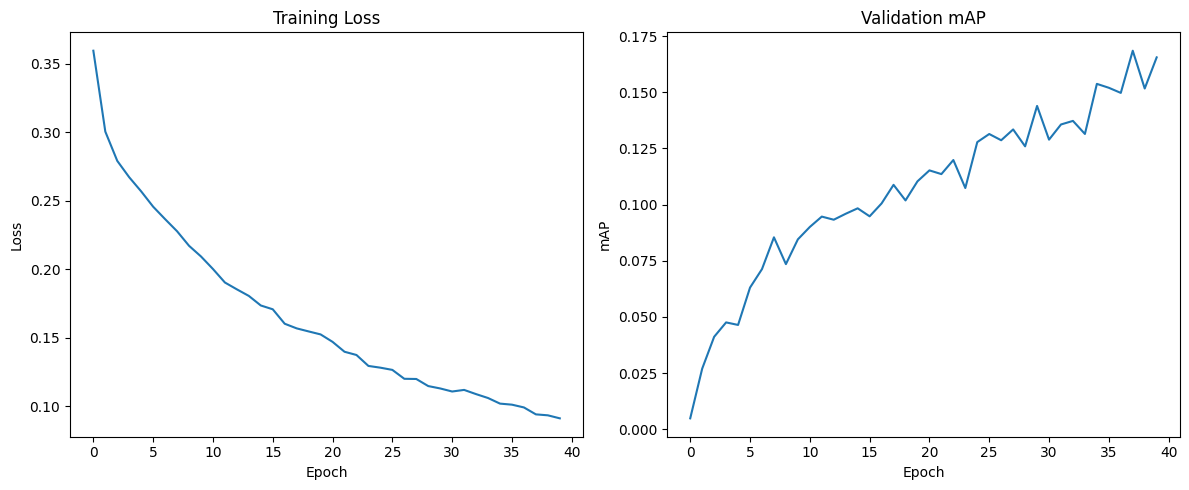

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_maps)
plt.title('Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')

plt.tight_layout()
plt.savefig('training_history.png')

# Final evaluation on test set
print("\nTest Set Evaluation:")
test_map = evaluate(model, test_loader, device)
print(f"Final Test mAP: {test_map:.4f}")

In [ ]:
# Visualize predictions on test set
visualize_predictions(model, test_dataset, device, num_images=5)

## Inference

In [ ]:
def detect_potholes(model, dataset, device, num_images=5, confidence_threshold=0.5):
    """
    Visualize model predictions on random images from the dataset
    """

    LOW_THRESHOLD = 10000
    MEDIUM_THRESHOLD = 40000

    model.eval()
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        # Get random image
        idx = np.random.randint(0, len(dataset))
        img, target = dataset[idx]

        # Get prediction
        with torch.no_grad():
            prediction = model([img.to(device)])[0]

        # Convert image for display
        img = img.permute(1, 2, 0).cpu().numpy()

        # Plot original image with ground truth
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title("Ground Truth")

        # Draw ground truth boxes
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='green', linewidth=2))

            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            label_item = label.item()
            if 0 <= label_item - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label_item - 1]]['name']  # Use label_item - 1
                plt.text(x1, y1, f"Class: {category_name}", color='white', backgroundcolor='green')
            else:
                print(f"Warning: Label {label_item} out of range for category IDs. Skipping this detection.")

        # Plot image with predictions
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(img)
        plt.title("Predictions")

        # Filter predictions by confidence threshold
        keep = prediction['scores'] > confidence_threshold
        boxes = prediction['boxes'][keep].cpu().numpy()
        labels = prediction['labels'][keep].cpu().numpy()
        scores = prediction['scores'][keep].cpu().numpy()

        # Draw predicted boxes
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='red', linewidth=2))
            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            if 0 <= label - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label - 1]]['name']  # Use label - 1

                #bbox1 = BBox2D( x1, y1, x2, y2)
                bbox1 = BoundingBox.from_xyxy(np.array([x1,y1]), np.array([x2,y2]))
                area = bbox1.height * bbox1.width

                sev_level = 'unknown'
                if area <= LOW_THRESHOLD:
                  sev_level = 'low'
                elif area <= MEDIUM_THRESHOLD:
                  sev_level = 'medium'
                elif area > MEDIUM_THRESHOLD:
                  sev_level = 'high'

                plt.text(x1, y1, f"Severity: {sev_level}, Area: {area:.2f}", color='white', backgroundcolor='red')
            else:
                print(f"Warning: Label {label} out of range for category IDs. Skipping this detection.")

    plt.tight_layout()
    plt.savefig('test_predictions.png')
    plt.show()

In [ ]:
# Load a pre-trained ResNet50 backbone
backbone = torchvision.models.resnet50(pretrained=True)
# Remove the fully connected layer and average pooling layer
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048  # ResNet50 has 2048 output channels for the last convolutional layer

# Anchor generator and ROI pooling
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Faster R-CNN model with ResNet50 backbone
fine_tuned_model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
fine_tuned_model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
fine_tuned_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

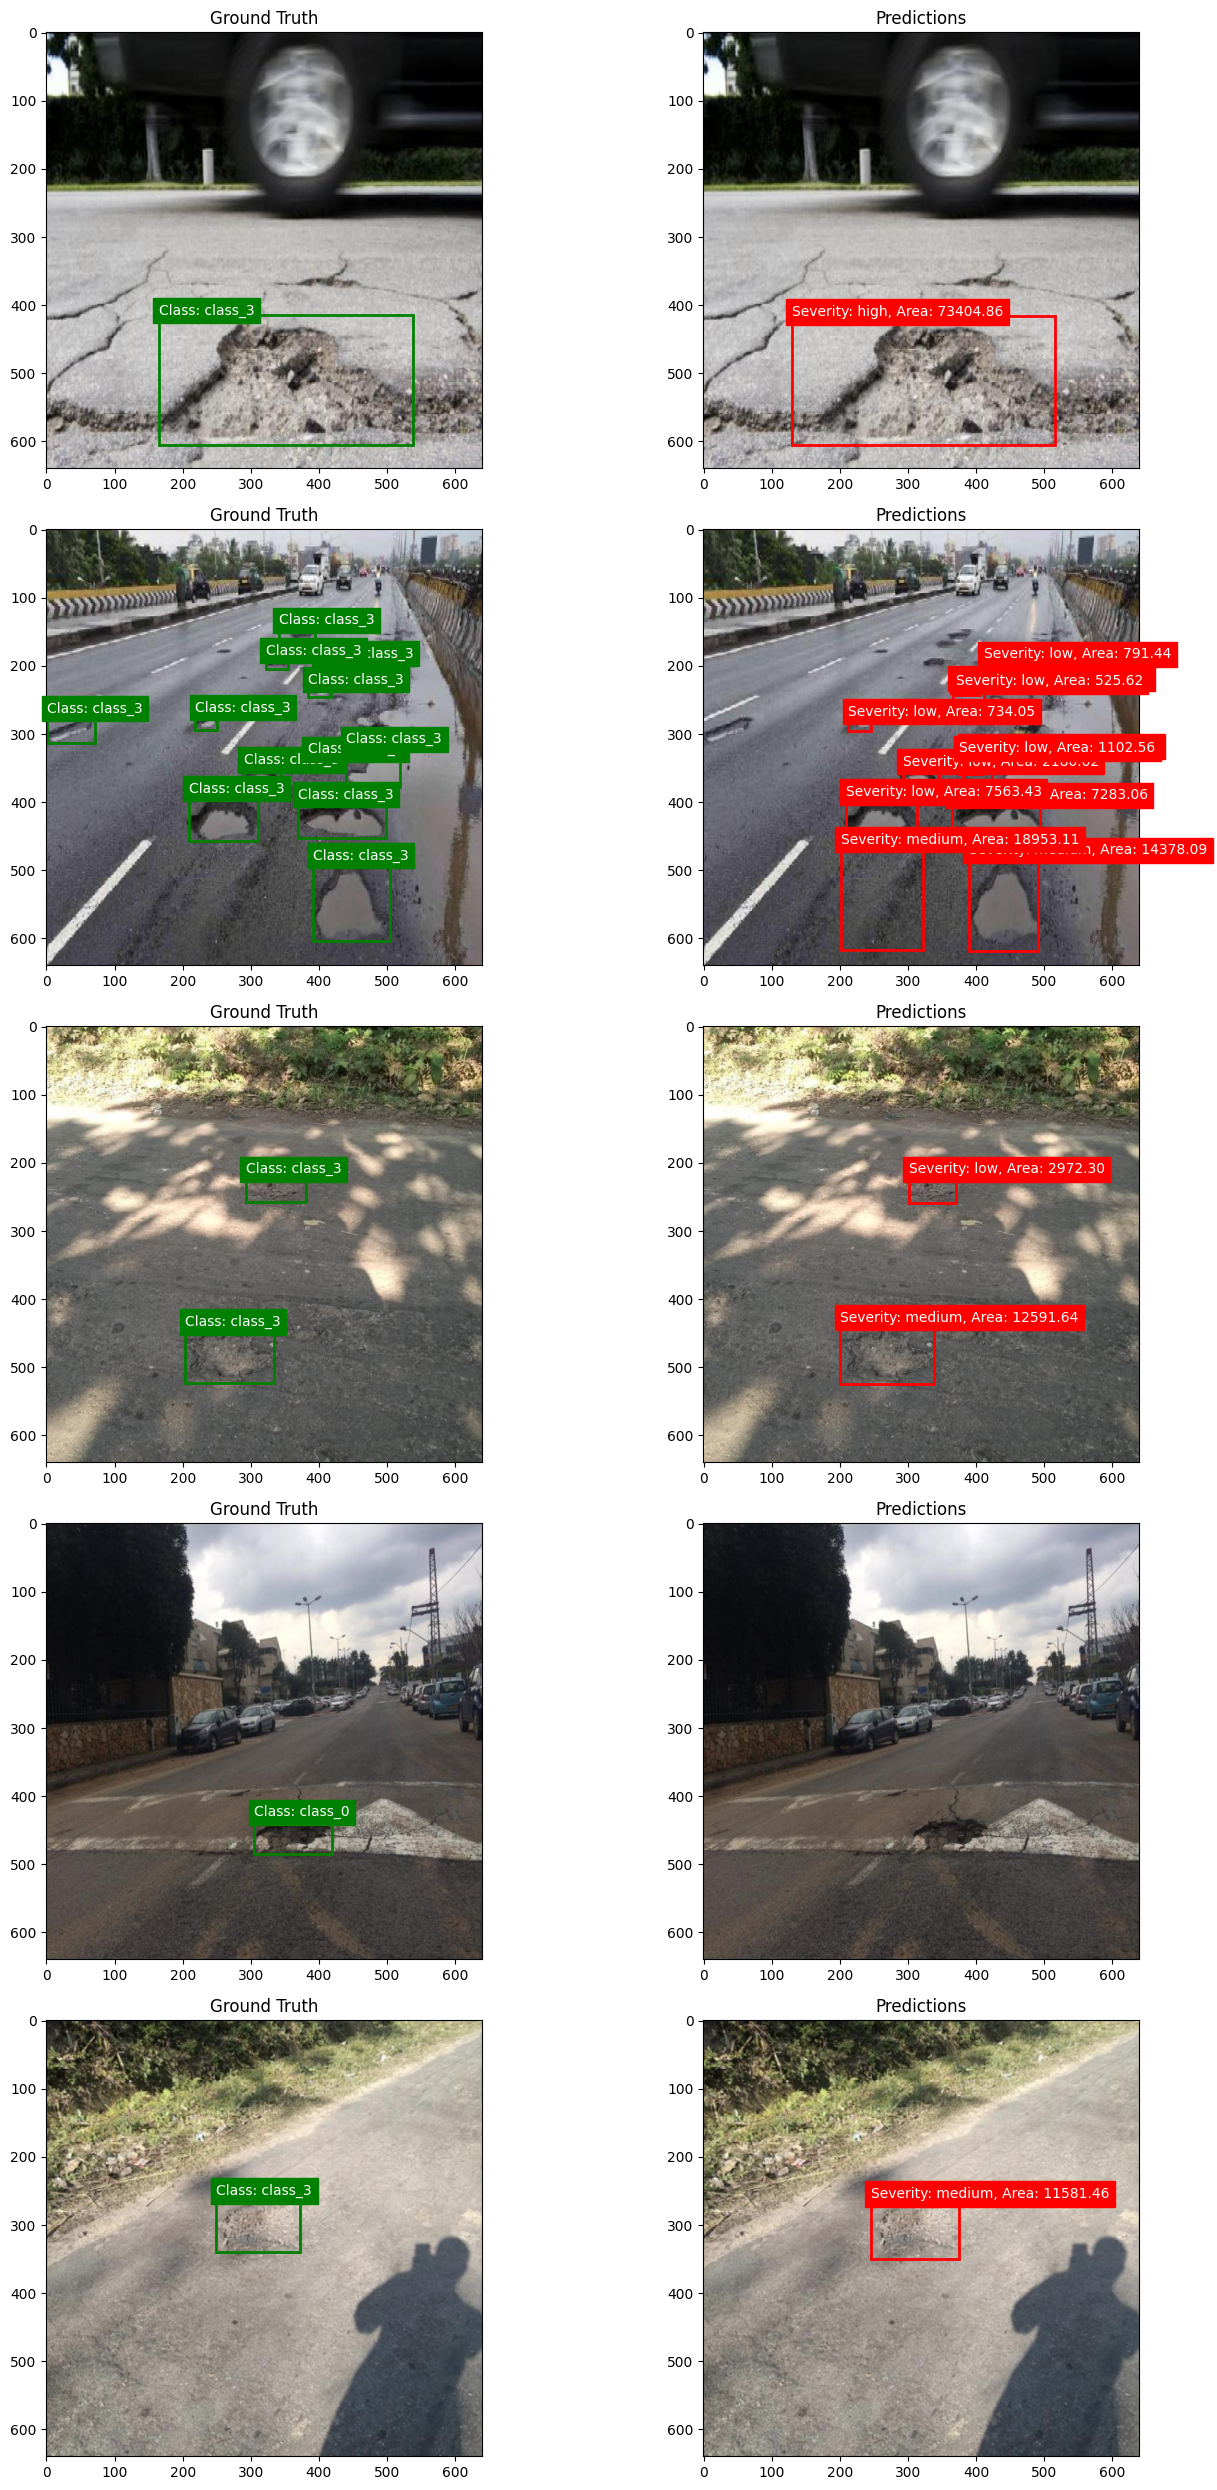

In [ ]:
detect_potholes(fine_tuned_model,test_dataset, device, num_images=5)